<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    if np.all(S_dict['S_mis'] == 0):
      print("no missing part in get path")
      n_deltas_mis = 1
      alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    print("n_delta_miss in get path ", n_deltas_mis)
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    print("dts deltas ", dts_deltas)
    print("mis deltas ", mis_deltas)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e3, 1e0, 1e0, S_dict)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [5]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      print("best alpha ----> ", best_alpha)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [6]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 1.5}
plots :  []
p_miss :  [1, 0.0, 0.0]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  3
multip_missing :  0
imp_method :  mi
post_imp :  mean
cov_strategy_between :  cond_var
cov_strategy :  std

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 289.01it/s]

 60%|██████    | 60/100 [00:00<00:00, 298.22it/s]

100%|██████████| 100/100 [00:00<00:00, 292.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [00:00<00:00, 322.25it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 313.56it/s]

100%|██████████| 100/100 [00:00<00:00, 282.51it/s]

100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.19it/s]

 51%|█████     | 51/100 [00:00<00:00, 256.81it/s]

100%|██████████| 100/100 [00:00<00:00, 277.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [00:00<00:00, 310.75it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 304.24it/s]

100%|██████████| 100/100 [00:00<00:00, 291.67it/s]

100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -113.78758062239382
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.64it/s]

 44%|████▍     | 44/100 [00:00<00:00, 224.34it/s]

100%|██████████| 100/100 [00:00<00:00, 259.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 219.78it/s]

 49%|████▉     | 49/100 [00:00<00:00, 246.11it/s]

100%|██████████| 100/100 [00:00<00:00, 252.45it/s]

100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  0.23924196617163926
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.63it/s]

 50%|█████     | 50/100 [00:00<00:00, 254.58it/s]

100%|██████████| 100/100 [00:00<00:00, 262.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [00:00<00:00, 312.70it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 301.58it/s]

100%|██████████| 100/100 [00:00<00:00, 274.49it/s]

100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3163570460910514
---------------------------------> best coeff  [-0.17251949  1.87325874]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 218.05it/s]

 51%|█████     | 51/100 [00:00<00:00, 256.16it/s]

100%|██████████| 100/100 [00:00<00:00, 274.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 268.68it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 268.62it/s]

100%|██████████| 100/100 [00:00<00:00, 267.97it/s]

100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  27.70375677815144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.10052765 0.        ]
 [0.         3.19712675]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.57it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.28it/s]

 42%|████▏     | 42/100 [00:00<00:00, 129.49it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 131.26it/s]

 71%|███████   | 71/100 [00:00<00:00, 136.64it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 138.16it/s]

100%|██████████| 100/100 [00:00<00:00, 134.85it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 130.50it/s]

 28%|██▊       | 28/100 [00:00<00:00, 125.78it/s]

 42%|████▏     | 42/100 [00:00<00:00, 128.54it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 128.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 127.26it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 131.15it/s]

100%|██████████| 100/100 [00:00<00:00, 130.95it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3195313563235347
---------------------------------> best coeff  [-0.16452851  1.86600494]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  1.1689379998776948
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 289.83it/s]

 61%|██████    | 61/100 [00:00<00:00, 303.96it/s]

100%|██████████| 100/100 [00:00<00:00, 305.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [00:00<00:00, 321.30it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 298.36it/s]

100%|██████████| 100/100 [00:00<00:00, 292.82it/s]

100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2882126925494832
---------------------------------> best coeff  [-0.25192905  1.93431052]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.20it/s]

 45%|████▌     | 45/100 [00:00<00:00, 225.55it/s]

100%|██████████| 100/100 [00:00<00:00, 260.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 30/100 [00:00<00:00, 293.67it/s]

 60%|██████    | 60/100 [00:00<00:00, 292.13it/s]

100%|██████████| 100/100 [00:00<00:00, 281.61it/s]

100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  55.66369435418517
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.06428963 0.        ]
 [0.         3.15334612]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.98it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.04it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.36it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 182.27it/s]

100%|██████████| 100/100 [00:00<00:00, 180.63it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.79it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.18it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.44it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 178.08it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 190.09it/s]

100%|██████████| 100/100 [00:00<00:00, 188.66it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.83it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.31it/s]

 42%|████▏     | 42/100 [00:00<00:00, 199.26it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 198.97it/s]

100%|██████████| 100/100 [00:00<00:00, 202.38it/s]

  0%|          | 0/3 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2977371577016266
---------------------------------> best coeff  [-0.2306427   1.93726916]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  2.0078550098809407
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 274.38it/s]

 61%|██████    | 61/100 [00:00<00:00, 305.85it/s]

100%|██████████| 100/100 [00:00<00:00, 301.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 284.11it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 290.60it/s]

100%|██████████| 100/100 [00:00<00:00, 278.39it/s]

100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.252366955080421
---------------------------------> best coeff  [-0.38183754  1.95997142]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.72it/s]

 49%|████▉     | 49/100 [00:00<00:00, 250.62it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 245.38it/s]

100%|██████████| 100/100 [00:00<00:00, 231.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 220.23it/s]

 46%|████▌     | 46/100 [00:00<00:00, 207.79it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 206.76it/s]

100%|██████████| 100/100 [00:00<00:00, 195.68it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  87.63365432115603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82474183 0.        ]
 [0.         3.24343293]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.76it/s]

 31%|███       | 31/100 [00:00<00:00, 159.08it/s]

 50%|█████     | 50/100 [00:00<00:00, 170.84it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 175.11it/s]

100%|██████████| 100/100 [00:00<00:00, 175.75it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.75it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.77it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.54it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 183.18it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 184.35it/s]

100%|██████████| 100/100 [00:00<00:00, 177.04it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.75it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.15it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.29it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 183.34it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 183.40it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.250547066087618
---------------------------------> best coeff  [-0.39892763  1.98719421]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.293480178868424
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.54it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 263.01it/s]

100%|██████████| 100/100 [00:00<00:00, 272.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 245.29it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 256.55it/s]

100%|██████████| 100/100 [00:00<00:00, 245.67it/s]

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.277041520717591
---------------------------------> best coeff  [-0.28307888  1.83285748]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.38it/s]

 45%|████▌     | 45/100 [00:00<00:00, 226.06it/s]

100%|██████████| 100/100 [00:00<00:00, 249.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 271.60it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 275.91it/s]

100%|██████████| 100/100 [00:00<00:00, 252.25it/s]

100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  364.9490796618162
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84650718 0.        ]
 [0.         3.30319075]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.28it/s]

 21%|██        | 21/100 [00:00<00:00, 106.39it/s]

 34%|███▍      | 34/100 [00:00<00:00, 114.02it/s]

 46%|████▌     | 46/100 [00:00<00:00, 112.90it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.15it/s]

 71%|███████   | 71/100 [00:00<00:00, 116.95it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 119.27it/s]

100%|██████████| 100/100 [00:00<00:00, 115.04it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.27it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.11it/s]

 42%|████▏     | 42/100 [00:00<00:00, 129.75it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 126.97it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 125.46it/s]

 81%|████████  | 81/100 [00:00<00:00, 124.60it/s]

100%|██████████| 100/100 [00:00<00:00, 124.13it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

  0%|          | 0/1

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2814652603703687
---------------------------------> best coeff  [-0.26205801  1.84277405]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.419260704037955
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 255.60it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 265.44it/s]

100%|██████████| 100/100 [00:00<00:00, 272.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 247.17it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 261.90it/s]

100%|██████████| 100/100 [00:00<00:00, 244.75it/s]

100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2459156679692875
---------------------------------> best coeff  [-0.42900713  1.97007459]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.18it/s]

 46%|████▌     | 46/100 [00:00<00:00, 231.79it/s]

100%|██████████| 100/100 [00:00<00:00, 245.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 235.53it/s]

 50%|█████     | 50/100 [00:00<00:00, 245.93it/s]

100%|██████████| 100/100 [00:00<00:00, 250.17it/s]

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  379.390710650634
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.85237287 0.        ]
 [0.         3.2299401 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.59it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 194.50it/s]

100%|██████████| 100/100 [00:00<00:00, 200.82it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.99it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 219.57it/s]

 45%|████▌     | 45/100 [00:00<00:00, 216.64it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 209.17it/s]

100%|██████████| 100/100 [00:00<00:00, 209.36it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.66it/s]

 40%|████      | 40/100 [00:00<00:00, 187.67it/s]

 60%|██████    | 60/100 [00:00<00:00, 192.35it/s]

100%|██████████| 100/100 [00:00<00:00, 202.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.80it/s]

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.286765731408339
---------------------------------> best coeff  [-0.24287079  1.8612217 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  8.778556603356586
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.05it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.76it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 190.18it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 201.00it/s]

100%|██████████| 100/100 [00:00<00:00, 194.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.23it/s]

 42%|████▏     | 42/100 [00:00<00:00, 204.15it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 200.13it/s]

100%|██████████| 100/100 [00:00<00:00, 192.58it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3127908207587424
---------------------------------> best coeff  [-0.1784122   1.78046905]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.16it/s]

 31%|███       | 31/100 [00:00<00:00, 163.04it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 182.35it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 199.07it/s]

100%|██████████| 100/100 [00:00<00:00, 191.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 236.22it/s]

 48%|████▊     | 48/100 [00:00<00:00, 223.54it/s]

 71%|███████   | 71/100 [00:00<00:00, 218.39it/s]

100%|██████████| 100/100 [00:00<00:00, 209.98it/s]

100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  477.0992542404042
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84892869 0.        ]
 [0.         3.24212003]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.69it/s]

 36%|███▌      | 36/100 [00:00<00:00, 179.01it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 182.85it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 174.85it/s]

100%|██████████| 100/100 [00:00<00:00, 177.74it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.77it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.77it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.06it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.65it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 181.80it/s]

100%|██████████| 100/100 [00:00<00:00, 180.09it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.77it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.50it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.19it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 179.70it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 179.21it/s]

100%|██████████| 100/100 [00

best alpha ---->  35.111917342151344
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.51119173e+01 1.00000000e-03 1.00000000e-03] , min score  2.503526633911037
---------------------------------> best coeff  [0.06000253 1.43736297]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  9.085157814851543
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 224.21it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 259.54it/s]

100%|██████████| 100/100 [00:00<00:00, 267.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 276.75it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 287.89it/s]

100%|██████████| 100/100 [00:00<00:00, 278.23it/s]

100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3338762205208226
---------------------------------> best coeff  [-0.14753571  1.70659623]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.29it/s]

 48%|████▊     | 48/100 [00:00<00:00, 245.32it/s]

100%|██████████| 100/100 [00:00<00:00, 254.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 236.31it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 261.68it/s]

100%|██████████| 100/100 [00:00<00:00, 264.57it/s]

100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  472.6154406500838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87983109 0.        ]
 [0.         3.13375892]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.56it/s]

 28%|██▊       | 28/100 [00:00<00:00, 127.25it/s]

 41%|████      | 41/100 [00:00<00:00, 127.28it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 129.08it/s]

 70%|███████   | 70/100 [00:00<00:00, 133.70it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 137.06it/s]

100%|██████████| 100/100 [00:00<00:00, 133.90it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.71it/s]

 29%|██▉       | 29/100 [00:00<00:00, 140.11it/s]

 44%|████▍     | 44/100 [00:00<00:00, 135.85it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 138.71it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 136.77it/s]

100%|██████████| 100/100 [00:00<00:00, 137.09it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.87it/s]

 27%|██▋       | 27/100 [00:

best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.590771141811893
---------------------------------> best coeff  [0.17636587 1.37670417]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  10.885404504020737
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.91it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 269.15it/s]

100%|██████████| 100/100 [00:00<00:00, 279.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 30/100 [00:00<00:00, 295.34it/s]

 61%|██████    | 61/100 [00:00<00:00, 300.20it/s]

100%|██████████| 100/100 [00:00<00:00, 283.27it/s]

100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.711471248483663
---------------------------------> best coeff  [0.25884196 1.24291487]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.37it/s]

 51%|█████     | 51/100 [00:00<00:00, 258.24it/s]

100%|██████████| 100/100 [00:00<00:00, 262.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 31%|███       | 31/100 [00:00<00:00, 307.66it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 298.69it/s]

100%|██████████| 100/100 [00:00<00:00, 292.94it/s]

100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3056569718372986
---------------------------------> best coeff  [-0.19154686  1.83220632]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  519.2234015464164
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87069837 0.        ]
 [0.         3.19813978]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.92it/s]

 38%|███▊      | 38/100 [00:00<00:00, 191.84it/s]

 60%|██████    | 60/100 [00:00<00:00, 200.94it/s]

100%|██████████| 100/100 [00:00<00:00, 200.08it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.99it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.88it/s]

 41%|████      | 41/100 [00:00<00:00, 199.39it/s]

 61%|██████    | 61/100 [00:00<00:00, 193.68it/s]

100%|██████████| 100/100 [00:00<00:00, 189.26it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.92it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.15it/s]

 39%|███▉      | 39/100 [00:00<00:00, 189.96it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 189.82it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 188.16it/s]

100%|██████████| 100/100 [00:00<00:00, 186.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

best alpha ---->  4.977023564332112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  42  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.97702356e+00 1.00000000e-03 1.00000000e-03] , min score  2.9466568277407483
---------------------------------> best coeff  [0.48438321 1.13029384]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.19154686,  1.83220632]), array([-0.17251949,  1.87325874]), array([-0.25192905,  1.93431052]), array([-0.38183754,  1.95997142]), array([-0.28307888,  1.83285748]), array([-0.42900713,  1.97007459]), array([-0.1784122 ,  1.78046905]), array([-0.14753571,  1.70659623]), array([0.25884196, 1.24291487])], 'l2_dist_best_coeff_gt': [np.float64(0.35113823715571046), np.float64(0.351150727456654), np.float64(0.256620936511151), np.float64(0.124758380355218), np.float64(0.2738455651708365), np.fl

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.30it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.36it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 182.87it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 184.18it/s]

100%|██████████| 100/100 [00:00<00:00, 182.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.66it/s]

 34%|███▍      | 34/100 [00:00<00:00, 160.52it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.88it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 167.07it/s]

100%|██████████| 100/100 [00:00<00:00, 160.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.50it/s]

 27%|██▋       | 27/100 [00:00<00:00, 140.51it/s]

 49%|████▉     | 49/100 [00:00<00:00, 173.78it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 180.52it/s]

100%|██████████| 100/100 [00:00<00:00, 177.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.21it/s]

 40%|████      | 40/100 [00:00<00:00, 171.05it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 176.03it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 176.40it/s]

100%|██████████| 100/100 [00:00<00:00, 166.89it/s]

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  764.3226245443439
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 248.02it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 272.09it/s]

100%|██████████| 100/100 [00:00<00:00, 262.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 254.69it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 278.85it/s]

100%|██████████| 100/100 [00:00<00:00, 268.86it/s]

100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2788599665307565
---------------------------------> best coeff  [-0.32801373  1.68748028]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  10.676688109818258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.09it/s]

 48%|████▊     | 48/100 [00:00<00:00, 244.22it/s]

100%|██████████| 100/100 [00:00<00:00, 254.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 235.98it/s]

 48%|████▊     | 48/100 [00:00<00:00, 231.07it/s]

100%|██████████| 100/100 [00:00<00:00, 247.02it/s]

100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.377673942284837
---------------------------------> best coeff  [-0.18333406  1.50596902]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.17it/s]

 42%|████▏     | 42/100 [00:00<00:00, 217.07it/s]

 70%|███████   | 70/100 [00:00<00:00, 242.83it/s]

100%|██████████| 100/100 [00:00<00:00, 233.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 214.22it/s]

 51%|█████     | 51/100 [00:00<00:00, 254.37it/s]

100%|██████████| 100/100 [00:00<00:00, 247.76it/s]

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  606.0169373757058
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.68030423 0.        ]
 [0.         2.80341411]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.25it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.72it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 169.60it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 182.15it/s]

100%|██████████| 100/100 [00:00<00:00, 178.05it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.77it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.07it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.22it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 187.74it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 182.05it/s]

100%|██████████| 100/100 [00:00<00:00, 178.24it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.76it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.87it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.11it/s]

 50%|█████     | 50/100 [00:00<00:00, 163.26it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.38it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4072812606959926
---------------------------------> best coeff  [-0.15956085  1.46290549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.972862196748004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 266.11it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 264.66it/s]

100%|██████████| 100/100 [00:00<00:00, 273.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 258.70it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 276.82it/s]

100%|██████████| 100/100 [00:00<00:00, 258.20it/s]

100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.389028370637382
---------------------------------> best coeff  [-0.15989606  1.48989417]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.88it/s]

 48%|████▊     | 48/100 [00:00<00:00, 244.38it/s]

100%|██████████| 100/100 [00:00<00:00, 257.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 258.41it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 280.57it/s]

100%|██████████| 100/100 [00:00<00:00, 270.46it/s]

100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  535.4834949774108
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70970962 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.00it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.98it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.60it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 139.03it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 154.78it/s]

100%|██████████| 100/100 [00:00<00:00, 150.50it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.18it/s]

 31%|███       | 31/100 [00:00<00:00, 150.05it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.12it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.00it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 163.92it/s]

100%|██████████| 100/100 [00:00<00:00, 159.58it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.09it/s]

 19%|█▉        | 19/100 [00:00<00:00, 92.63it/s]

 31%|███       | 31/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4118604872882767
---------------------------------> best coeff  [-0.1255586   1.45888326]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  9.851044293250897
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 224.17it/s]

 50%|█████     | 50/100 [00:00<00:00, 247.17it/s]

100%|██████████| 100/100 [00:00<00:00, 249.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.19it/s]

 40%|████      | 40/100 [00:00<00:00, 198.63it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 220.63it/s]

100%|██████████| 100/100 [00:00<00:00, 216.37it/s]

100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3680641566535154
---------------------------------> best coeff  [-0.23237992  1.52141978]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.28it/s]

 40%|████      | 40/100 [00:00<00:00, 207.40it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 229.38it/s]

100%|██████████| 100/100 [00:00<00:00, 223.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 224.83it/s]

 47%|████▋     | 47/100 [00:00<00:00, 229.37it/s]

 71%|███████   | 71/100 [00:00<00:00, 231.97it/s]

100%|██████████| 100/100 [00:00<00:00, 226.27it/s]

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  629.9689748342389
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.67469437 0.        ]
 [0.         2.81567946]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.07it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.67it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 188.72it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 183.93it/s]

100%|██████████| 100/100 [00:00<00:00, 184.99it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.84it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.69it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.19it/s]

 60%|██████    | 60/100 [00:00<00:00, 197.62it/s]

 80%|████████  | 80/100 [00:00<00:00, 196.74it/s]

100%|██████████| 100/100 [00:00<00:00, 192.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.88it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.94it/s]

 37%|███▋      | 37/100 [00:00<00:00, 184.84it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 178.11it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 181.36it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3392517081623083
---------------------------------> best coeff  [-0.23291856  1.56741963]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  7.322885849578515
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 245.61it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 263.23it/s]

100%|██████████| 100/100 [00:00<00:00, 269.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.12it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.77it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 182.82it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 184.84it/s]

100%|██████████| 100/100 [00:00<00:00, 176.81it/s]

100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.5012255623235506
---------------------------------> best coeff  [-0.15718596  1.34784809]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 82.51it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.65it/s]

 48%|████▊     | 48/100 [00:00<00:00, 165.36it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 180.55it/s]

100%|██████████| 100/100 [00:00<00:00, 173.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.99it/s]

 42%|████▏     | 42/100 [00:00<00:00, 201.67it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 197.47it/s]

100%|██████████| 100/100 [00:00<00:00, 189.85it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  481.91107981845505
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6733122  0.        ]
 [0.         2.93648392]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.10it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.36it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.41it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 189.25it/s]

100%|██████████| 100/100 [00:00<00:00, 183.84it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.83it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.85it/s]

 37%|███▋      | 37/100 [00:00<00:00, 184.77it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 181.80it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 186.99it/s]

100%|██████████| 100/100 [00:00<00:00, 183.52it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.82it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.00it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.08it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 191.12it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 191.56it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.43420025885636
---------------------------------> best coeff  [-0.19435968  1.42888717]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  8.525374679163246
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S d

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.61it/s]

 51%|█████     | 51/100 [00:00<00:00, 249.28it/s]

100%|██████████| 100/100 [00:00<00:00, 240.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.53it/s]

 49%|████▉     | 49/100 [00:00<00:00, 246.10it/s]

100%|██████████| 100/100 [00:00<00:00, 243.00it/s]

100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4954975135712743
---------------------------------> best coeff  [-0.14951962  1.35322196]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.00it/s]

 49%|████▉     | 49/100 [00:00<00:00, 247.33it/s]

100%|██████████| 100/100 [00:00<00:00, 260.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 201.01it/s]

 49%|████▉     | 49/100 [00:00<00:00, 243.59it/s]

100%|██████████| 100/100 [00:00<00:00, 246.99it/s]

100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  508.7146750155604
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69894083 0.        ]
 [0.         3.03383337]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.98it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.34it/s]

 36%|███▌      | 36/100 [00:00<00:00, 115.20it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.86it/s]

 60%|██████    | 60/100 [00:00<00:00, 109.37it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 114.04it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 111.11it/s]

100%|██████████| 100/100 [00:00<00:00, 113.21it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.09it/s]

 28%|██▊       | 28/100 [00:00<00:00, 125.99it/s]

 41%|████      | 41/100 [00:00<00:00, 123.58it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 127.54it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 123.44it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 126.49it/s]

100%|██████████| 100/100 [00:00<00:00, 127.28it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.435913998949857
---------------------------------> best coeff  [-0.21179435  1.42901549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.614963519041943
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.34it/s]

 50%|█████     | 50/100 [00:00<00:00, 254.28it/s]

100%|██████████| 100/100 [00:00<00:00, 262.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 249.04it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 276.16it/s]

100%|██████████| 100/100 [00:00<00:00, 267.66it/s]

100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4952773617459707
---------------------------------> best coeff  [-0.10756596  1.35110792]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.89it/s]

 48%|████▊     | 48/100 [00:00<00:00, 243.97it/s]

100%|██████████| 100/100 [00:00<00:00, 257.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 252.75it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 281.64it/s]

100%|██████████| 100/100 [00:00<00:00, 271.27it/s]

100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  397.17708597955027
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78522612 0.        ]
 [0.         3.00602071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.31it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.07it/s]

 47%|████▋     | 47/100 [00:00<00:00, 159.19it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 170.54it/s]

100%|██████████| 100/100 [00:00<00:00, 169.34it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.68it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.79it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.52it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.39it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 180.65it/s]

100%|██████████| 100/100 [00:00<00:00, 177.74it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.72it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.05it/s]

 30%|███       | 30/100 [00:00<00:00, 153.79it/s]

 49%|████▉     | 49/100 [00:00<00:00, 169.40it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 176.37it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4361151451212177
---------------------------------> best coeff  [-0.1345862   1.42405176]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.569708423167516
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 244.75it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 264.11it/s]

100%|██████████| 100/100 [00:00<00:00, 276.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.44it/s]

 46%|████▌     | 46/100 [00:00<00:00, 225.01it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 201.42it/s]

100%|██████████| 100/100 [00:00<00:00, 193.71it/s]

100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.554364513441958
---------------------------------> best coeff  [-0.04916584  1.28571623]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.71it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.50it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 183.41it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 193.74it/s]

100%|██████████| 100/100 [00:00<00:00, 192.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 221.13it/s]

 46%|████▌     | 46/100 [00:00<00:00, 186.70it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 190.34it/s]

100%|██████████| 100/100 [00:00<00:00, 191.39it/s]

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  464.0733181108758
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83125665 0.        ]
 [0.         3.08810026]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.83it/s]

 29%|██▉       | 29/100 [00:00<00:00, 148.26it/s]

 48%|████▊     | 48/100 [00:00<00:00, 165.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 178.38it/s]

100%|██████████| 100/100 [00:00<00:00, 171.79it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.71it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.89it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.44it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.79it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 179.62it/s]

100%|██████████| 100/100 [00:00<00:00, 170.18it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.69it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.96it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.80it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 177.91it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 181.16it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4691851656289616
---------------------------------> best coeff  [-0.0480657   1.38950019]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  6.047915659791714
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.83it/s]

 48%|████▊     | 48/100 [00:00<00:00, 240.88it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 244.07it/s]

100%|██████████| 100/100 [00:00<00:00, 237.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.68it/s]

 42%|████▏     | 42/100 [00:00<00:00, 208.39it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 230.83it/s]

100%|██████████| 100/100 [00:00<00:00, 219.62it/s]

100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.5266278277196443
---------------------------------> best coeff  [-0.12406399  1.31747861]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  12.738710409072397
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.65430012 0.        ]
 [0.         2.87615324]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.34it/s]

 37%|███▋      | 37/100 [00:00<00:00, 193.68it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 217.61it/s]

100%|██████████| 100/100 [00:00<00:00, 208.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.99it/s]

 44%|████▍     | 44/100 [00:00<00:00, 219.89it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 227.48it/s]

100%|██████████| 100/100 [00:00<00:00, 217.63it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.278859966530749
---------------------------------> best coeff  [-0.32801373  1.68748028]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.88476671 0.95871775]
crush test------------------------------------------------->  551.9724359092979
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.89710197 0.        ]
 [0.         3.1931384 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 81.89it/s]

 19%|█▉        | 19/100 [00:00<00:00, 89.84it/s]

 30%|███       | 30/100 [00:00<00:00, 98.11it/s]

 43%|████▎     | 43/100 [00:00<00:00, 106.99it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 112.91it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 113.25it/s]

 80%|████████  | 80/100 [00:00<00:00, 110.60it/s]

100%|██████████| 100/100 [00:00<00:00, 108.98it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.08it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.56it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.93it/s]

 48%|████▊     | 48/100 [00:00<00:00, 120.09it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 142.26it/s]

100%|██████████| 100/100 [00:00<00:00, 139.65it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.58692922100192
---------------------------------> best coeff  [0.08402116 1.27090149]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.32801373,  1.68748028]), array([-0.18333406,  1.50596902]), array([-0.15989606,  1.48989417]), array([-0.23237992,  1.52141978]), array([-0.15718596,  1.34784809]), array([-0.14951962,  1.35322196]), array([-0.10756596,  1.35110792]), array([-0.04916584,  1.28571623]), array([-0.12406399,  1.31747861])], 'l2_dist_best_coeff_gt': [np.float64(0.3567181672861984), np.float64(0.5868082561891151), np.float64(0.6130894247599145), np.float64(0.548324296526961), np.float64(0.7367656200568296), np.float64(0.7356346473792053), np.float64(0.7

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.59it/s]

 48%|████▊     | 48/100 [00:00<00:00, 240.08it/s]

100%|██████████| 100/100 [00:00<00:00, 249.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.23it/s]

 46%|████▌     | 46/100 [00:00<00:00, 231.05it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 248.30it/s]

100%|██████████| 100/100 [00:00<00:00, 231.45it/s]

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.74it/s]

 44%|████▍     | 44/100 [00:00<00:00, 225.34it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 230.91it/s]

100%|██████████| 100/100 [00:00<00:00, 222.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.36it/s]

 44%|████▍     | 44/100 [00:00<00:00, 222.85it/s]

 70%|███████   | 70/100 [00:00<00:00, 236.73it/s]

100%|██████████| 100/100 [00:00<00:00, 220.40it/s]

100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  654.5458776923518
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.18it/s]

 48%|████▊     | 48/100 [00:00<00:00, 241.78it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 238.27it/s]

100%|██████████| 100/100 [00:00<00:00, 238.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.96it/s]

 42%|████▏     | 42/100 [00:00<00:00, 210.81it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 216.92it/s]

100%|██████████| 100/100 [00:00<00:00, 212.85it/s]

100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  9.105556704167553
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.25it/s]

 43%|████▎     | 43/100 [00:00<00:00, 216.33it/s]

 71%|███████   | 71/100 [00:00<00:00, 243.77it/s]

100%|██████████| 100/100 [00:00<00:00, 235.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.35it/s]

 46%|████▌     | 46/100 [00:00<00:00, 229.23it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 241.48it/s]

100%|██████████| 100/100 [00:00<00:00, 229.05it/s]

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


best alpha ---->  3.1257158496882367
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.12571585e+00 1.00000000e-03 1.00000000e-03] , min score  2.256217747815332
---------------------------------> best coeff  [-0.44242552  2.0249638 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:20,  4.86it/s]

 29%|██▉       | 29/100 [00:00<00:00, 117.45it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 172.17it/s]

100%|██████████| 100/100 [00:00<00:00, 170.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.16it/s]

 44%|████▍     | 44/100 [00:00<00:00, 220.96it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 221.14it/s]

100%|██████████| 100/100 [00:00<00:00, 218.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  545.2665438117212
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.63161151]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.05it/s]

 31%|███       | 31/100 [00:00<00:00, 155.15it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.60it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.15it/s]

100%|██████████| 100/100 [00:00<00:00, 165.99it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.26it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.01it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 172.32it/s]

 70%|███████   | 70/100 [00:00<00:00, 173.98it/s]

100%|██████████| 100/100 [00:00<00:00, 170.94it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.18it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.49it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.43it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 173.80it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.001      1.        ] , min score  2.2512713385163834
---------------------------------> best coeff  [-0.43912158  1.96736258]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.093701019765158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 205.38it/s]

 49%|████▉     | 49/100 [00:00<00:00, 245.53it/s]

100%|██████████| 100/100 [00:00<00:00, 252.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.52it/s]

 40%|████      | 40/100 [00:00<00:00, 195.88it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 221.22it/s]

100%|██████████| 100/100 [00:00<00:00, 215.39it/s]

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2787409727761165
---------------------------------> best coeff  [-0.32126512  1.97773703]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.73it/s]

 42%|████▏     | 42/100 [00:00<00:00, 217.51it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 240.80it/s]

100%|██████████| 100/100 [00:00<00:00, 230.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.58it/s]

 40%|████      | 40/100 [00:00<00:00, 192.91it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 211.51it/s]

100%|██████████| 100/100 [00:00<00:00, 213.87it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  693.7129519791004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71320243 0.        ]
 [0.         2.59881079]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.73it/s]

 30%|███       | 30/100 [00:00<00:00, 145.66it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.93it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 162.37it/s]

100%|██████████| 100/100 [00:00<00:00, 166.49it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.47it/s]

 31%|███       | 31/100 [00:00<00:00, 152.54it/s]

 47%|████▋     | 47/100 [00:00<00:00, 149.21it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.67it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 163.52it/s]

100%|██████████| 100/100 [00:00<00:00, 157.59it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.01it/s]

 30%|███       | 30/100 [00:00<00:00, 150.67it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.67it/s]

 63%|██████▎   | 63/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.290952634606611
---------------------------------> best coeff  [-0.27212821  1.94561733]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  8.191328787312612
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.40it/s]

 50%|█████     | 50/100 [00:00<00:00, 244.46it/s]

100%|██████████| 100/100 [00:00<00:00, 260.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 225.20it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 268.17it/s]

100%|██████████| 100/100 [00:00<00:00, 267.85it/s]

100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.295319370239148
---------------------------------> best coeff  [-0.24998347  1.91933304]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.20it/s]

 40%|████      | 40/100 [00:00<00:00, 206.80it/s]

 70%|███████   | 70/100 [00:00<00:00, 247.61it/s]

100%|██████████| 100/100 [00:00<00:00, 228.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 234.48it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 256.39it/s]

100%|██████████| 100/100 [00:00<00:00, 255.90it/s]

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  507.6617961633116
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.71096399 0.        ]
 [0.         2.62864994]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.73it/s]

 31%|███       | 31/100 [00:00<00:00, 154.12it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.34it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 170.98it/s]

100%|██████████| 100/100 [00:00<00:00, 166.64it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.66it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.63it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.24it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 175.87it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 182.14it/s]

100%|██████████| 100/100 [00:00<00:00, 176.31it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.71it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.86it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.85it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 172.40it/s]

 71%|███████   | 71/100 [00:00<00:00, 147.51it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.318440789421701
---------------------------------> best coeff  [-0.18674711  1.88338467]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  6.437974770476365
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.91it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.41it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.70it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 168.61it/s]

100%|██████████| 100/100 [00:00<00:00, 164.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 150.80it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.13it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 191.01it/s]

100%|██████████| 100/100 [00:00<00:00, 201.99it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.280181494464155
---------------------------------> best coeff  [-0.31936488  1.77012865]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.80it/s]

 40%|████      | 40/100 [00:00<00:00, 210.55it/s]

 70%|███████   | 70/100 [00:00<00:00, 248.16it/s]

100%|██████████| 100/100 [00:00<00:00, 236.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.84it/s]

 40%|████      | 40/100 [00:00<00:00, 199.31it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 226.67it/s]

100%|██████████| 100/100 [00:00<00:00, 215.69it/s]

100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  511.09392982370144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78105687 0.        ]
 [0.         2.63475074]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.21it/s]

 26%|██▌       | 26/100 [00:00<00:00, 133.49it/s]

 44%|████▍     | 44/100 [00:00<00:00, 153.02it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 162.19it/s]

 80%|████████  | 80/100 [00:00<00:00, 168.18it/s]

100%|██████████| 100/100 [00:00<00:00, 157.61it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.25it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.75it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.55it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 168.88it/s]

100%|██████████| 100/100 [00:00<00:00, 163.06it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.78it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.28it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.95it/s]

 68%|██████▊   | 68/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.292187769992606
---------------------------------> best coeff  [-0.23928025  1.80046546]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  4.1830939841846595
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.83it/s]

 42%|████▏     | 42/100 [00:00<00:00, 212.29it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 218.96it/s]

100%|██████████| 100/100 [00:00<00:00, 221.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.68it/s]

 41%|████      | 41/100 [00:00<00:00, 202.06it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 225.15it/s]

100%|██████████| 100/100 [00:00<00:00, 215.64it/s]

100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.310612958389756
---------------------------------> best coeff  [-0.50634148  1.74061928]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.01it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.76it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 193.77it/s]

100%|██████████| 100/100 [00:00<00:00, 206.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.42it/s]

 40%|████      | 40/100 [00:00<00:00, 191.58it/s]

 60%|██████    | 60/100 [00:00<00:00, 182.73it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 184.99it/s]

100%|██████████| 100/100 [00:00<00:00, 175.74it/s]

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  378.61065695555135
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82837421 0.        ]
 [0.         2.72919206]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.39it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.95it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.60it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 168.41it/s]

100%|██████████| 100/100 [00:00<00:00, 167.81it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.67it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.32it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.77it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.94it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.23it/s]

100%|██████████| 100/100 [00:00<00:00, 162.39it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.08it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.89it/s]

 49%|████▉     | 49/100 [00:00<00:00, 161.51it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 170.08it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2630528711379294
---------------------------------> best coeff  [-0.46497768  1.84740275]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -2.4632448578452144
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.73it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.69it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 176.07it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 184.95it/s]

100%|██████████| 100/100 [00:00<00:00, 177.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.25it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.93it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 174.47it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 163.91it/s]

100%|██████████| 100/100 [00:00<00:00, 161.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4146555560092855
---------------------------------> best coeff  [-0.18241932  1.47276827]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 146.39it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.18it/s]

 50%|█████     | 50/100 [00:00<00:00, 160.08it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 160.49it/s]

100%|██████████| 100/100 [00:00<00:00, 168.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.13it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.96it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 162.37it/s]

 70%|███████   | 70/100 [00:00<00:00, 149.64it/s]

100%|██████████| 100/100 [00:00<00:00, 152.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -40.16094473275535
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87956799 0.        ]
 [0.         2.69348391]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.11it/s]

 22%|██▏       | 22/100 [00:00<00:00, 108.55it/s]

 35%|███▌      | 35/100 [00:00<00:00, 116.64it/s]

 47%|████▋     | 47/100 [00:00<00:00, 109.37it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 108.87it/s]

 70%|███████   | 70/100 [00:00<00:00, 110.59it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 112.04it/s]

100%|██████████| 100/100 [00:00<00:00, 111.31it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.65it/s]

 22%|██▏       | 22/100 [00:00<00:00, 99.20it/s] 

 33%|███▎      | 33/100 [00:00<00:00, 98.85it/s]

 44%|████▍     | 44/100 [00:00<00:00, 101.76it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 102.21it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 96.58it/s] 

 76%|███████▌  | 76/100 [00:00<00:00, 96.02it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 98.19it/s]

100%|██████████| 100

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.270700965604041
---------------------------------> best coeff  [-0.38647264  1.79769597]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -1.362061079877412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.41it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.68it/s]

 70%|███████   | 70/100 [00:00<00:00, 236.40it/s]

100%|██████████| 100/100 [00:00<00:00, 227.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.02it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.37it/s]

 61%|██████    | 61/100 [00:00<00:00, 202.13it/s]

100%|██████████| 100/100 [00:00<00:00, 206.48it/s]

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4656701807772077
---------------------------------> best coeff  [-0.04917382  1.41539686]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.03it/s]

 40%|████      | 40/100 [00:00<00:00, 204.41it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 226.63it/s]

100%|██████████| 100/100 [00:00<00:00, 219.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.52it/s]

 40%|████      | 40/100 [00:00<00:00, 199.47it/s]

 61%|██████    | 61/100 [00:00<00:00, 203.21it/s]

100%|██████████| 100/100 [00:00<00:00, 205.75it/s]

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  -26.282910255274704
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.8226297  0.        ]
 [0.         2.81144325]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.01it/s]

 34%|███▍      | 34/100 [00:00<00:00, 173.56it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 180.09it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 190.39it/s]

100%|██████████| 100/100 [00:00<00:00, 180.93it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.80it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.39it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.19it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 171.31it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 174.50it/s]

100%|██████████| 100/100 [00:00<00:00, 171.87it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.74it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.51it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.90it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 181.09it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 179.47it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2577126271717614
---------------------------------> best coeff  [-0.44088761  1.8662778 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  2.228217527850782
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.22it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.55it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.00it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 188.11it/s]

100%|██████████| 100/100 [00:00<00:00, 187.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.44it/s]

 42%|████▏     | 42/100 [00:00<00:00, 174.35it/s]

 60%|██████    | 60/100 [00:00<00:00, 165.61it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 158.76it/s]

100%|██████████| 100/100 [00:00<00:00, 156.24it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  31.992671377973846
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.19926714e+01 1.00000000e-03 1.00000000e-03] , min score  2.4078709486500567
---------------------------------> best coeff  [1.86544343e-09 1.68056497e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  10.909097961539198
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.83358414 0.        ]
 [0.         2.58422114]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S miss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.71it/s]

 24%|██▍       | 24/100 [00:00<00:00, 124.67it/s]

 39%|███▉      | 39/100 [00:00<00:00, 134.32it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 152.00it/s]

100%|██████████| 100/100 [00:00<00:00, 170.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.88it/s]

 42%|████▏     | 42/100 [00:00<00:00, 206.96it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 229.72it/s]

100%|██████████| 100/100 [00:00<00:00, 220.18it/s]

100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2549087849657017
---------------------------------> best coeff  [-0.41201656  1.9709792 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94452805 0.86140705]
crush test------------------------------------------------->  211.76186123045997
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.78118335 0.        ]
 [0.         2.77150642]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.62it/s]

 29%|██▉       | 29/100 [00:00<00:00, 139.85it/s]

 44%|████▍     | 44/100 [00:00<00:00, 144.05it/s]

 61%|██████    | 61/100 [00:00<00:00, 151.07it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 160.32it/s]

100%|██████████| 100/100 [00:00<00:00, 153.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.49it/s]

 31%|███       | 31/100 [00:00<00:00, 153.05it/s]

 49%|████▉     | 49/100 [00:00<00:00, 163.11it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 161.52it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 162.41it/s]

100%|██████████| 100/100 [00:00<00:00, 156.67it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.34it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.28it/s]

 48%|████▊     | 48/100 [00:

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.414501488065685
---------------------------------> best coeff  [2.04375227e-04 1.60117293e+00]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.41201656,  1.9709792 ]), array([-0.44242552,  2.0249638 ]), array([-0.32126512,  1.97773703]), array([-0.24998347,  1.91933304]), array([-0.31936488,  1.77012865]), array([-0.50634148,  1.74061928]), array([-0.18241932,  1.47276827]), array([-0.04917382,  1.41539686]), array([1.86544343e-09, 1.68056497e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.09264606287335898), np.float64(0.06275357872032947), np.float64(0.1801160698364908), np.float64(0.262707866742507), np.float64(0.29235

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.99it/s]

 40%|████      | 40/100 [00:00<00:00, 199.70it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 238.34it/s]

100%|██████████| 100/100 [00:00<00:00, 231.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.62it/s]

 44%|████▍     | 44/100 [00:00<00:00, 212.34it/s]

 70%|███████   | 70/100 [00:00<00:00, 233.53it/s]

100%|██████████| 100/100 [00:00<00:00, 223.94it/s]

100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.25it/s]

 30%|███       | 30/100 [00:00<00:00, 153.63it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 189.91it/s]

100%|██████████| 100/100 [00:00<00:00, 205.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.38it/s]

 42%|████▏     | 42/100 [00:00<00:00, 192.62it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 192.32it/s]

100%|██████████| 100/100 [00:00<00:00, 190.03it/s]

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -138.49507713227072
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.35it/s]

 41%|████      | 41/100 [00:00<00:00, 206.47it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 237.05it/s]

100%|██████████| 100/100 [00:00<00:00, 228.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.72it/s]

 42%|████▏     | 42/100 [00:00<00:00, 192.79it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 215.47it/s]

100%|██████████| 100/100 [00:00<00:00, 200.83it/s]

100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789294
---------------------------------> best coeff  [-0.24970623  2.06894507]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.7112798690249673
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.51it/s]

 40%|████      | 40/100 [00:00<00:00, 205.23it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 235.52it/s]

100%|██████████| 100/100 [00:00<00:00, 234.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.12it/s]

 42%|████▏     | 42/100 [00:00<00:00, 203.73it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 232.62it/s]

100%|██████████| 100/100 [00:00<00:00, 209.11it/s]

100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.287669186137414
---------------------------------> best coeff  [-0.25352312  2.01797113]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.19it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.49it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 187.03it/s]

100%|██████████| 100/100 [00:00<00:00, 209.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.23it/s]

 42%|████▏     | 42/100 [00:00<00:00, 207.17it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 233.05it/s]

100%|██████████| 100/100 [00:00<00:00, 212.64it/s]

100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -224.7596933011205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.44920925 0.        ]
 [0.         2.80270435]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 67.12it/s]

 18%|█▊        | 18/100 [00:00<00:00, 89.81it/s]

 37%|███▋      | 37/100 [00:00<00:00, 132.90it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 139.25it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 159.49it/s]

100%|██████████| 100/100 [00:00<00:00, 149.40it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.49it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.80it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.20it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.85it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 179.75it/s]

100%|██████████| 100/100 [00:00<00:00, 175.88it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.44it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.25it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.12it/s]

 65%|██████▌   | 65/100 [00:00<

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  200  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 1.   ] , min score  2.276352449018283
---------------------------------> best coeff  [-0.22002193  1.91304885]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -3.0289768557778
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 214.89it/s]

 48%|████▊     | 48/100 [00:00<00:00, 237.94it/s]

100%|██████████| 100/100 [00:00<00:00, 251.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 211.42it/s]

 45%|████▌     | 45/100 [00:00<00:00, 219.28it/s]

 71%|███████   | 71/100 [00:00<00:00, 236.98it/s]

100%|██████████| 100/100 [00:00<00:00, 225.73it/s]

100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3011274677228366
---------------------------------> best coeff  [-0.14256411  1.80955301]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.82it/s]

 33%|███▎      | 33/100 [00:00<00:00, 172.02it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 225.10it/s]

100%|██████████| 100/100 [00:00<00:00, 220.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 219.45it/s]

 47%|████▋     | 47/100 [00:00<00:00, 227.93it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 234.31it/s]

100%|██████████| 100/100 [00:00<00:00, 227.47it/s]

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -140.22355098083742
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49528756 0.        ]
 [0.         2.66880425]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.04it/s]

 28%|██▊       | 28/100 [00:00<00:00, 141.69it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.46it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 165.50it/s]

100%|██████████| 100/100 [00:00<00:00, 164.90it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.64it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.42it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.58it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.95it/s]

 71%|███████   | 71/100 [00:00<00:00, 179.45it/s]

100%|██████████| 100/100 [00:00<00:00, 175.88it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.21it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.97it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 170.01it/s]

100%|██████████| 100/100 [00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.300996257317273
---------------------------------> best coeff  [-0.14633846  1.83003581]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.956456130476978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.42it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.69it/s]

 45%|████▌     | 45/100 [00:00<00:00, 147.49it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 154.84it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 160.14it/s]

100%|██████████| 100/100 [00:00<00:00, 154.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.53it/s]

 34%|███▍      | 34/100 [00:00<00:00, 159.55it/s]

 50%|█████     | 50/100 [00:00<00:00, 152.78it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 146.05it/s]

 81%|████████  | 81/100 [00:00<00:00, 143.52it/s]

100%|██████████| 100/100 [00:00<00:00, 141.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3460309186130677
---------------------------------> best coeff  [-0.05425459  1.73331232]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.25it/s]

 28%|██▊       | 28/100 [00:00<00:00, 145.00it/s]

 48%|████▊     | 48/100 [00:00<00:00, 168.35it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 202.36it/s]

100%|██████████| 100/100 [00:00<00:00, 192.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.57it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.48it/s]

 60%|██████    | 60/100 [00:00<00:00, 195.22it/s]

100%|██████████| 100/100 [00:00<00:00, 195.66it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -273.53793102336124
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.52282814 0.        ]
 [0.         2.66309204]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.50it/s]

 29%|██▉       | 29/100 [00:00<00:00, 140.31it/s]

 44%|████▍     | 44/100 [00:00<00:00, 140.30it/s]

 60%|██████    | 60/100 [00:00<00:00, 147.61it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 156.84it/s]

100%|██████████| 100/100 [00:00<00:00, 151.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.25it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.37it/s]

 43%|████▎     | 43/100 [00:00<00:00, 143.52it/s]

 60%|██████    | 60/100 [00:00<00:00, 152.66it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 157.43it/s]

100%|██████████| 100/100 [00:00<00:00, 145.67it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.46it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.54it/s]

 29%|██▉       | 29/100 [00:00<00:00, 141.94it/s]

 45%|████▌     | 45/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3676499223268888
---------------------------------> best coeff  [-0.01837111  1.68640619]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.66270700106243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.02it/s]

 40%|████      | 40/100 [00:00<00:00, 198.68it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 228.45it/s]

100%|██████████| 100/100 [00:00<00:00, 221.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 202.66it/s]

 42%|████▏     | 42/100 [00:00<00:00, 173.61it/s]

 60%|██████    | 60/100 [00:00<00:00, 166.34it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 164.33it/s]

100%|██████████| 100/100 [00:00<00:00, 165.56it/s]

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3310357049698274
---------------------------------> best coeff  [-0.08075874  1.74088187]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.61it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.01it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 175.38it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 184.43it/s]

100%|██████████| 100/100 [00:00<00:00, 175.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.34it/s]

 40%|████      | 40/100 [00:00<00:00, 190.64it/s]

 60%|██████    | 60/100 [00:00<00:00, 194.20it/s]

 80%|████████  | 80/100 [00:00<00:00, 194.75it/s]

100%|██████████| 100/100 [00:00<00:00, 178.34it/s]

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -294.1624966431945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.58359914 0.        ]
 [0.         2.68791682]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.66it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.70it/s]

 37%|███▋      | 37/100 [00:00<00:00, 119.63it/s]

 50%|█████     | 50/100 [00:00<00:00, 122.10it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 133.03it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 139.97it/s]

100%|██████████| 100/100 [00:00<00:00, 130.83it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.21it/s]

 26%|██▌       | 26/100 [00:00<00:00, 129.19it/s]

 40%|████      | 40/100 [00:00<00:00, 133.83it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 143.72it/s]

 71%|███████   | 71/100 [00:00<00:00, 144.23it/s]

100%|██████████| 100/100 [00:00<00:00, 137.40it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.21it/s]

 26%|██▌       | 26/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.373325243452153
---------------------------------> best coeff  [-0.01310554  1.74745186]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -0.7224505435061159
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.83it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.10it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 225.88it/s]

100%|██████████| 100/100 [00:00<00:00, 223.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.26it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.99it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.77it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 186.85it/s]

100%|██████████| 100/100 [00:00<00:00, 179.41it/s]

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2447627553279506
---------------------------------> best coeff  [-0.33119816  1.79021349]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.15it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.66it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.84it/s]

100%|██████████| 100/100 [00:00<00:00, 200.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.81it/s]

 40%|████      | 40/100 [00:00<00:00, 184.29it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 202.21it/s]

100%|██████████| 100/100 [00:00<00:00, 196.89it/s]

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -51.430354490854796
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55347772 0.        ]
 [0.         2.70343436]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.49it/s]

 25%|██▌       | 25/100 [00:00<00:00, 126.03it/s]

 41%|████      | 41/100 [00:00<00:00, 139.25it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 141.95it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 146.16it/s]

100%|██████████| 100/100 [00:00<00:00, 139.08it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.26it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.30it/s]

 43%|████▎     | 43/100 [00:00<00:00, 141.26it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 147.05it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 151.36it/s]

100%|██████████| 100/100 [00:00<00:00, 146.49it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.70it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.30it/s]

 42%|████▏     | 42/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.30434386500675
---------------------------------> best coeff  [-0.14516816  1.70031162]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -4.131033299834031
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.82it/s]

 40%|████      | 40/100 [00:00<00:00, 196.57it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 217.08it/s]

100%|██████████| 100/100 [00:00<00:00, 205.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.10it/s]

 40%|████      | 40/100 [00:00<00:00, 186.65it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 186.17it/s]

 80%|████████  | 80/100 [00:00<00:00, 192.99it/s]

100%|██████████| 100/100 [00:00<00:00, 185.49it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3651282346362272
---------------------------------> best coeff  [-0.08881403  1.5453914 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.96it/s]

 30%|███       | 30/100 [00:00<00:00, 146.28it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.57it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 157.88it/s]

100%|██████████| 100/100 [00:00<00:00, 169.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.97it/s]

 38%|███▊      | 38/100 [00:00<00:00, 174.37it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 178.81it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 189.96it/s]

100%|██████████| 100/100 [00:00<00:00, 184.40it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -307.2806198344825
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53762126 0.        ]
 [0.         2.72818251]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.25it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.99it/s]

 38%|███▊      | 38/100 [00:00<00:00, 129.64it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 136.50it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 142.27it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 141.51it/s]

100%|██████████| 100/100 [00:00<00:00, 134.23it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.46it/s]

 24%|██▍       | 24/100 [00:00<00:00, 115.09it/s]

 39%|███▉      | 39/100 [00:00<00:00, 128.71it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.91it/s]

 70%|███████   | 70/100 [00:00<00:00, 141.71it/s]

100%|██████████| 100/100 [00:00<00:00, 139.93it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.45it/s]

 29%|██▉       | 29/100 [00:

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4334954656598535
---------------------------------> best coeff  [0.03894699 1.49749887]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.480548730208051
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.59it/s]

 39%|███▉      | 39/100 [00:00<00:00, 190.78it/s]

 60%|██████    | 60/100 [00:00<00:00, 198.96it/s]

100%|██████████| 100/100 [00:00<00:00, 211.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.41it/s]

 40%|████      | 40/100 [00:00<00:00, 190.65it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 201.89it/s]

100%|██████████| 100/100 [00:00<00:00, 204.69it/s]

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4284039395881463
---------------------------------> best coeff  [0.02433659 1.49194579]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.04it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.08it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 172.67it/s]

100%|██████████| 100/100 [00:00<00:00, 197.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.94it/s]

 40%|████      | 40/100 [00:00<00:00, 187.88it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 213.82it/s]

100%|██████████| 100/100 [00:00<00:00, 206.37it/s]

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -244.41659046726735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.55966589 0.        ]
 [0.         2.67407226]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.99it/s]

 18%|█▊        | 18/100 [00:00<00:00, 85.69it/s]

 27%|██▋       | 27/100 [00:00<00:00, 86.55it/s]

 36%|███▌      | 36/100 [00:00<00:00, 83.94it/s]

 47%|████▋     | 47/100 [00:00<00:00, 89.57it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 94.44it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 110.50it/s]

100%|██████████| 100/100 [00:00<00:00, 106.70it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.86it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.64it/s]

 39%|███▉      | 39/100 [00:00<00:00, 128.93it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 134.71it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 134.52it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 137.30it/s]

100%|██████████| 100/100 [00:00<00:00, 128.09it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

  0%|          | 0/100 [0

best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.448829430965259
---------------------------------> best coeff  [0.05046939 1.47030185]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -6.38922273848274
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.41it/s]

 39%|███▉      | 39/100 [00:00<00:00, 197.46it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 219.34it/s]

100%|██████████| 100/100 [00:00<00:00, 209.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.05it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.82it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 186.59it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 183.80it/s]

100%|██████████| 100/100 [00:00<00:00, 186.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4167941132623407
---------------------------------> best coeff  [0.04089834 1.56400611]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -2.3082512855378456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.42819828 0.        ]
 [0.         2.79585704]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.15it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.42it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 191.84it/s]

100%|██████████| 100/100 [00:00<00:00, 201.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 200.20it/s]

 42%|████▏     | 42/100 [00:00<00:00, 197.60it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 190.42it/s]

100%|██████████| 100/100 [00:00<00:00, 196.83it/s]

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3104955109789507
---------------------------------> best coeff  [-0.24970623  2.06894507]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.80939943 0.93195235]
crush test------------------------------------------------->  -225.29823571044685
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70749088 0.        ]
 [0.         2.7155328 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.08it/s]

 17%|█▋        | 17/100 [00:00<00:01, 81.85it/s]

 29%|██▉       | 29/100 [00:00<00:00, 95.14it/s]

 40%|████      | 40/100 [00:00<00:00, 100.47it/s]

 51%|█████     | 51/100 [00:00<00:00, 102.93it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 99.94it/s] 

 74%|███████▍  | 74/100 [00:00<00:00, 104.05it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 108.37it/s]

100%|██████████| 100/100 [00:00<00:00, 101.16it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.00it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.85it/s]

 26%|██▌       | 26/100 [00:00<00:00, 111.31it/s]

 38%|███▊      | 38/100 [00:00<00:00, 110.40it/s]

 51%|█████     | 51/100 [00:00<00:00, 115.90it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 118.37it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 118.46it/s]

100%|██████████| 100/100 [00:00<00:00, 116.87it/s]

 67%|██████▋   | 2

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4202575082756654
---------------------------------> best coeff  [0.02231264 1.51290216]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.24970623,  2.06894507]), array([-0.25352312,  2.01797113]), array([-0.14256411,  1.80955301]), array([-0.05425459,  1.73331232]), array([-0.08075874,  1.74088187]), array([-0.33119816,  1.79021349]), array([-0.08881403,  1.5453914 ]), array([0.02433659, 1.49194579]), array([0.04089834, 1.56400611])], 'l2_dist_best_coeff_gt': [np.float64(0.25961586144132354), np.float64(0.2471311683823122), np.float64(0.4050067528942222), np.float64(0.5194336295131805), np.float64(0.4928543833799325), np.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.34it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.11it/s]

 61%|██████    | 61/100 [00:00<00:00, 210.57it/s]

100%|██████████| 100/100 [00:00<00:00, 210.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.03it/s]

 40%|████      | 40/100 [00:00<00:00, 183.56it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 183.24it/s]

100%|██████████| 100/100 [00:00<00:00, 193.23it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.82it/s]

 28%|██▊       | 28/100 [00:00<00:00, 143.47it/s]

 48%|████▊     | 48/100 [00:00<00:00, 166.10it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 173.94it/s]

100%|██████████| 100/100 [00:00<00:00, 174.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.26it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.77it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 163.85it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 183.48it/s]

100%|██████████| 100/100 [00:00<00:00, 183.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  15.077839647713095
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.69it/s]

 31%|███       | 31/100 [00:00<00:00, 152.09it/s]

 47%|████▋     | 47/100 [00:00<00:00, 146.58it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 143.89it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.89it/s]

100%|██████████| 100/100 [00:00<00:00, 153.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.05it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.68it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 162.77it/s]

 70%|███████   | 70/100 [00:00<00:00, 155.72it/s]

100%|██████████| 100/100 [00:00<00:00, 156.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500583
---------------------------------> best coeff  [-0.38991117  1.69077611]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  2.027996137827004
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.90it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.89it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 193.12it/s]

100%|██████████| 100/100 [00:00<00:00, 203.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.66it/s]

 40%|████      | 40/100 [00:00<00:00, 174.18it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 191.65it/s]

100%|██████████| 100/100 [00:00<00:00, 190.62it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.279709831247905
---------------------------------> best coeff  [-0.40791419  1.67497175]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.34it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.52it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 213.18it/s]

100%|██████████| 100/100 [00:00<00:00, 214.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 191.08it/s]

 40%|████      | 40/100 [00:00<00:00, 189.09it/s]

 60%|██████    | 60/100 [00:00<00:00, 193.11it/s]

 80%|████████  | 80/100 [00:00<00:00, 194.64it/s]

100%|██████████| 100/100 [00:00<00:00, 192.73it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  148.8741769135179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.16599891 0.        ]
 [0.         3.30993099]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.52it/s]

 28%|██▊       | 28/100 [00:00<00:00, 129.64it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.12it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 155.21it/s]

 80%|████████  | 80/100 [00:00<00:00, 163.08it/s]

100%|██████████| 100/100 [00:00<00:00, 154.30it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.54it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.36it/s]

 30%|███       | 30/100 [00:00<00:00, 146.28it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.82it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 167.93it/s]

100%|██████████| 100/100 [00:00<00:00, 161.38it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.41it/s]

 28%|██▊       | 28/100 [00:00<00:00, 140.40it/s]

 45%|████▌     | 45/100 [00:00<00:00, 153.43it/s]

 62%|██████▏   | 62/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.283384000489365
---------------------------------> best coeff  [-0.39801662  1.6644346 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.468586044603243
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.72it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.66it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 193.65it/s]

100%|██████████| 100/100 [00:00<00:00, 213.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 219.55it/s]

 45%|████▌     | 45/100 [00:00<00:00, 204.47it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 188.61it/s]

100%|██████████| 100/100 [00:00<00:00, 184.61it/s]

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3215897336367872
---------------------------------> best coeff  [-0.43235209  1.61741588]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.99it/s]

 31%|███       | 31/100 [00:00<00:00, 153.70it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.97it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 189.02it/s]

100%|██████████| 100/100 [00:00<00:00, 186.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 193.46it/s]

 41%|████      | 41/100 [00:00<00:00, 200.01it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 199.63it/s]

100%|██████████| 100/100 [00:00<00:00, 183.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  269.5006932287854
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.25797359 0.        ]
 [0.         3.33980045]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.83it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.58it/s]

 42%|████▏     | 42/100 [00:00<00:00, 148.53it/s]

 60%|██████    | 60/100 [00:00<00:00, 157.93it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 163.93it/s]

100%|██████████| 100/100 [00:00<00:00, 153.08it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.50it/s]

 26%|██▌       | 26/100 [00:00<00:00, 116.95it/s]

 42%|████▏     | 42/100 [00:00<00:00, 135.43it/s]

 61%|██████    | 61/100 [00:00<00:00, 155.19it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 162.93it/s]

100%|██████████| 100/100 [00:00<00:00, 150.28it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.87it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.61it/s]

 46%|████▌     | 46/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3123194920090833
---------------------------------> best coeff  [-0.42368038  1.62720308]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  5.111803928967923
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.64it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.97it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 211.24it/s]

100%|██████████| 100/100 [00:00<00:00, 211.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 192.39it/s]

 40%|████      | 40/100 [00:00<00:00, 172.60it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 176.48it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 183.24it/s]

100%|██████████| 100/100 [00:00<00:00, 179.71it/s]

100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3031298422890267
---------------------------------> best coeff  [-0.42056435  1.64016647]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.21it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.78it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.99it/s]

100%|██████████| 100/100 [00:00<00:00, 197.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.59it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.82it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.05it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 190.14it/s]

100%|██████████| 100/100 [00:00<00:00, 185.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  344.3122147371429
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.33577759 0.        ]
 [0.         3.31888563]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 99.27it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.75it/s]

 38%|███▊      | 38/100 [00:00<00:00, 129.08it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 139.81it/s]

 71%|███████   | 71/100 [00:00<00:00, 150.47it/s]

100%|██████████| 100/100 [00:00<00:00, 144.33it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.43it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.33it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.76it/s]

 45%|████▌     | 45/100 [00:00<00:00, 151.77it/s]

 61%|██████    | 61/100 [00:00<00:00, 153.82it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 147.99it/s]

100%|██████████| 100/100 [00:00<00:00, 145.96it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.66it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.48it/s]

 46%|████▌     | 46/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2971250583212615
---------------------------------> best coeff  [-0.40460401  1.64314477]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.122981631920061
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.48it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.28it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 218.72it/s]

100%|██████████| 100/100 [00:00<00:00, 218.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 211.72it/s]

 44%|████▍     | 44/100 [00:00<00:00, 206.25it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 206.38it/s]

100%|██████████| 100/100 [00:00<00:00, 207.79it/s]

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.316629553021935
---------------------------------> best coeff  [-0.34464616  1.59048152]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.69it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.03it/s]

 50%|█████     | 50/100 [00:00<00:00, 171.25it/s]

 71%|███████   | 71/100 [00:00<00:00, 183.76it/s]

100%|██████████| 100/100 [00:00<00:00, 187.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 210.35it/s]

 44%|████▍     | 44/100 [00:00<00:00, 209.40it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 205.23it/s]

100%|██████████| 100/100 [00:00<00:00, 204.62it/s]

100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  135.89379937837944
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.37233862 0.        ]
 [0.         3.12085267]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.49it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.32it/s]

 41%|████      | 41/100 [00:00<00:00, 139.02it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 154.05it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 158.56it/s]

100%|██████████| 100/100 [00:00<00:00, 150.78it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.60it/s]

 26%|██▌       | 26/100 [00:00<00:00, 117.89it/s]

 39%|███▉      | 39/100 [00:00<00:00, 118.47it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 120.49it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 122.56it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 125.24it/s]

100%|██████████| 100/100 [00:00<00:00, 120.43it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.95it/s]

 22%|██▏       | 22/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.315879909261051
---------------------------------> best coeff  [-0.26926717  1.57636376]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  4.568728364530211
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.22it/s]

 34%|███▍      | 34/100 [00:00<00:00, 155.54it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 172.09it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 176.62it/s]

100%|██████████| 100/100 [00:00<00:00, 177.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.62it/s]

 42%|████▏     | 42/100 [00:00<00:00, 206.25it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 204.47it/s]

100%|██████████| 100/100 [00:00<00:00, 205.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2957651655691222
---------------------------------> best coeff  [-0.21785026  1.61815947]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.74it/s]

 32%|███▏      | 32/100 [00:00<00:00, 164.67it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 183.18it/s]

100%|██████████| 100/100 [00:00<00:00, 197.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 221.66it/s]

 46%|████▌     | 46/100 [00:00<00:00, 210.55it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 213.55it/s]

100%|██████████| 100/100 [00:00<00:00, 206.30it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  334.53928123727064
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29149822 0.        ]
 [0.         2.85287554]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.55it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 124.83it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 138.22it/s]

 70%|███████   | 70/100 [00:00<00:00, 144.21it/s]

100%|██████████| 100/100 [00:00<00:00, 139.30it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.31it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.93it/s]

 42%|████▏     | 42/100 [00:00<00:00, 139.66it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 134.92it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 142.14it/s]

100%|██████████| 100/100 [00:00<00:00, 137.96it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.60it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.73it/s]

 38%|███▊      | 38/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4000747401624785
---------------------------------> best coeff  [0.02256604 1.51624247]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  1.2800240257766224
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.49it/s]

 40%|████      | 40/100 [00:00<00:00, 194.69it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 214.96it/s]

100%|██████████| 100/100 [00:00<00:00, 216.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.66it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.74it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 184.20it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.78it/s]

100%|██████████| 100/100 [00:00<00:00, 167.64it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.350228601287512
---------------------------------> best coeff  [-0.1682134   1.51761083]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.36it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.31it/s]

 48%|████▊     | 48/100 [00:00<00:00, 163.69it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.03it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 163.37it/s]

100%|██████████| 100/100 [00:00<00:00, 158.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.64it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.80it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 181.62it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.71it/s]

100%|██████████| 100/100 [00:00<00:00, 168.46it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  68.6886023180512
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.27053389 0.        ]
 [0.         2.70867447]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.15it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.98it/s]

 38%|███▊      | 38/100 [00:00<00:00, 128.50it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 138.39it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 142.30it/s]

100%|██████████| 100/100 [00:00<00:00, 140.51it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.93it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.90it/s]

 38%|███▊      | 38/100 [00:00<00:00, 124.05it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 137.55it/s]

 70%|███████   | 70/100 [00:00<00:00, 145.45it/s]

100%|██████████| 100/100 [00:00<00:00, 139.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 116.52it/s]

 28%|██▊       | 28/100 [00:00<00:00, 132.57it/s]

 43%|████▎     | 43/100 [00:

best alpha ---->  2.1544346900318843
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469e+00 1.00000000e-03 1.00000000e-03] , min score  2.473611934998189
---------------------------------> best coeff  [0.1501355  1.51154567]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.7281970287430114
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.82it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.84it/s]

 61%|██████    | 61/100 [00:00<00:00, 208.20it/s]

100%|██████████| 100/100 [00:00<00:00, 200.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.79it/s]

 40%|████      | 40/100 [00:00<00:00, 188.48it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 176.51it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 180.93it/s]

100%|██████████| 100/100 [00:00<00:00, 180.70it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3900040930015733
---------------------------------> best coeff  [-0.23596562  1.46068094]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.08it/s]

 33%|███▎      | 33/100 [00:00<00:00, 165.67it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 175.44it/s]

 70%|███████   | 70/100 [00:00<00:00, 176.05it/s]

100%|██████████| 100/100 [00:00<00:00, 172.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 194.84it/s]

 40%|████      | 40/100 [00:00<00:00, 181.59it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 177.17it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 173.11it/s]

100%|██████████| 100/100 [00:00<00:00, 168.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  115.2833340559983
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.26412504 0.        ]
 [0.         2.76855138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.50it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.38it/s]

 36%|███▌      | 36/100 [00:00<00:00, 120.96it/s]

 50%|█████     | 50/100 [00:00<00:00, 127.77it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 131.99it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 126.08it/s]

100%|██████████| 100/100 [00:00<00:00, 124.76it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.58it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.77it/s]

 38%|███▊      | 38/100 [00:00<00:00, 127.50it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 133.84it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 134.60it/s]

 81%|████████  | 81/100 [00:00<00:00, 136.07it/s]

100%|██████████| 100/100 [00:00<00:00, 131.88it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.598726826422488
---------------------------------> best coeff  [0.27683641 1.39021035]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  3.431990136735487
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S da

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.85it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.15it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 193.56it/s]

100%|██████████| 100/100 [00:00<00:00, 197.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.06it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.65it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.91it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 162.50it/s]

100%|██████████| 100/100 [00:00<00:00, 168.25it/s]

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  3.5580715981858733
---------------------------------> best coeff  [0.51339667 0.54811505]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  0.2512973274618854
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.33308868 0.        ]
 [0.         3.26137904]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.60it/s]

 51%|█████     | 51/100 [00:00<00:00, 173.70it/s]

 71%|███████   | 71/100 [00:00<00:00, 183.43it/s]

100%|██████████| 100/100 [00:00<00:00, 182.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.62it/s]

 38%|███▊      | 38/100 [00:00<00:00, 162.98it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 163.70it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 167.30it/s]

100%|██████████| 100/100 [00:00<00:00, 159.10it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2681882501500574
---------------------------------> best coeff  [-0.38991117  1.69077611]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11102956 1.08712635]
crush test------------------------------------------------->  276.05352339203773
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29427367 0.        ]
 [0.         2.85518843]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.99it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.98it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.14it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 135.61it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 140.57it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 145.91it/s]

100%|██████████| 100/100 [00:00<00:00, 138.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.77it/s]

 24%|██▍       | 24/100 [00:00<00:00, 112.22it/s]

 36%|███▌      | 36/100 [00:00<00:00, 112.08it/s]

 49%|████▉     | 49/100 [00:00<00:00, 117.99it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 130.53it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 133.52it/s]

100%|██████████| 100/100 [00:00<00:00, 128.00it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.7983787848880453
---------------------------------> best coeff  [0.23884098 1.05261038]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.38991117,  1.69077611]), array([-0.40791419,  1.67497175]), array([-0.43235209,  1.61741588]), array([-0.42056435,  1.64016647]), array([-0.34464616,  1.59048152]), array([-0.21785026,  1.61815947]), array([-0.1682134 ,  1.51761083]), array([-0.23596562,  1.46068094]), array([0.51339667, 0.54811505])], 'l2_dist_best_coeff_gt': [np.float64(0.3282361417189569), np.float64(0.3378211901159054), np.float64(0.3885187919352997), np.float64(0.36849720630938315), np.float64(0.43799565945532576), np.float64(0.47477432870635866), np.float64

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.94it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.32it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.94it/s]

 71%|███████   | 71/100 [00:00<00:00, 178.44it/s]

100%|██████████| 100/100 [00:00<00:00, 166.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.30it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.30it/s]

 46%|████▌     | 46/100 [00:00<00:00, 151.50it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 154.15it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 147.83it/s]

100%|██████████| 100/100 [00:00<00:00, 142.12it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.40it/s]

 26%|██▌       | 26/100 [00:00<00:00, 133.42it/s]

 45%|████▌     | 45/100 [00:00<00:00, 157.03it/s]

 61%|██████    | 61/100 [00:00<00:00, 156.80it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 154.69it/s]

100%|██████████| 100/100 [00:00<00:00, 149.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.48it/s]

 30%|███       | 30/100 [00:00<00:00, 151.32it/s]

 49%|████▉     | 49/100 [00:00<00:00, 166.50it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 174.29it/s]

100%|██████████| 100/100 [00:00<00:00, 168.07it/s]

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1311.1450651364921
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 169.56it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.47it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 181.50it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 190.70it/s]

100%|██████████| 100/100 [00:00<00:00, 182.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.40it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.90it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.13it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 176.92it/s]

100%|██████████| 100/100 [00:00<00:00, 171.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2774018142483294
---------------------------------> best coeff  [-0.48893568  1.93349751]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.34074845298671
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.20it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.60it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 162.13it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.25it/s]

100%|██████████| 100/100 [00:00<00:00, 178.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.35it/s]

 42%|████▏     | 42/100 [00:00<00:00, 194.33it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 192.20it/s]

100%|██████████| 100/100 [00:00<00:00, 186.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.2855813830912854
---------------------------------> best coeff  [-0.43190698  2.02979004]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.21it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.08it/s]

 45%|████▌     | 45/100 [00:00<00:00, 154.00it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 169.59it/s]

100%|██████████| 100/100 [00:00<00:00, 170.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.83it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.28it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 179.96it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 179.27it/s]

100%|██████████| 100/100 [00:00<00:00, 175.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1583.530241992397
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.84683258 0.        ]
 [0.         3.23856065]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.89it/s]

 20%|██        | 20/100 [00:00<00:00, 95.28it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.52it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.10it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 114.65it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 127.54it/s]

100%|██████████| 100/100 [00:00<00:00, 122.79it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 118.39it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.91it/s]

 43%|████▎     | 43/100 [00:00<00:00, 143.43it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 138.82it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 144.26it/s]

100%|██████████| 100/100 [00:00<00:00, 138.96it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.53it/s]

 26%|██▌       | 26/100 [00:00<

best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  2.2863014259510526
---------------------------------> best coeff  [-0.43373532  2.03519502]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  26.661673043082697
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.22it/s]

 39%|███▉      | 39/100 [00:00<00:00, 192.13it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 214.93it/s]

100%|██████████| 100/100 [00:00<00:00, 216.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 219.51it/s]

 44%|████▍     | 44/100 [00:00<00:00, 211.68it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 200.43it/s]

100%|██████████| 100/100 [00:00<00:00, 206.16it/s]

100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.282734329235057
---------------------------------> best coeff  [-0.4274535   2.00853849]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.38it/s]

 35%|███▌      | 35/100 [00:00<00:00, 180.99it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 197.78it/s]

100%|██████████| 100/100 [00:00<00:00, 199.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 217.61it/s]

 44%|████▍     | 44/100 [00:00<00:00, 214.62it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 216.15it/s]

100%|██████████| 100/100 [00:00<00:00, 204.80it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1617.368781499003
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87432424 0.        ]
 [0.         3.34134256]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.87it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.77it/s]

 36%|███▌      | 36/100 [00:00<00:00, 118.61it/s]

 49%|████▉     | 49/100 [00:00<00:00, 120.60it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 135.60it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 145.53it/s]

100%|██████████| 100/100 [00:00<00:00, 134.87it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 119.36it/s]

 25%|██▌       | 25/100 [00:00<00:00, 112.42it/s]

 38%|███▊      | 38/100 [00:00<00:00, 119.32it/s]

 50%|█████     | 50/100 [00:00<00:00, 113.67it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 111.98it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 115.34it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 111.57it/s]

100%|██████████| 100/100 [00:00<00:00, 111.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

  0%|          | 0/

best alpha ---->  0.14508287784959398
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  204  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14508288 0.001      1.        ] , min score  2.279465879257678
---------------------------------> best coeff  [-0.446471    2.00217549]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  27.172303965016894
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.53it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.02it/s]

 44%|████▍     | 44/100 [00:00<00:00, 140.93it/s]

 61%|██████    | 61/100 [00:00<00:00, 151.09it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 150.52it/s]

100%|██████████| 100/100 [00:00<00:00, 152.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.17it/s]

 42%|████▏     | 42/100 [00:00<00:00, 198.18it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 188.96it/s]

 81%|████████  | 81/100 [00:00<00:00, 182.79it/s]

100%|██████████| 100/100 [00:00<00:00, 181.64it/s]

100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  2.2916154717035164
---------------------------------> best coeff  [-0.43091642  2.05707739]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.84it/s]

 37%|███▋      | 37/100 [00:00<00:00, 186.17it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 192.03it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 191.32it/s]

100%|██████████| 100/100 [00:00<00:00, 190.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.40it/s]

 42%|████▏     | 42/100 [00:00<00:00, 202.31it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 203.29it/s]

100%|██████████| 100/100 [00:00<00:00, 192.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1663.0414404042158
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76541946 0.        ]
 [0.         3.37452797]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.46it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.24it/s]

 45%|████▌     | 45/100 [00:00<00:00, 147.06it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 159.51it/s]

 81%|████████  | 81/100 [00:00<00:00, 165.72it/s]

100%|██████████| 100/100 [00:00<00:00, 155.47it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.02it/s]

 30%|███       | 30/100 [00:00<00:00, 139.75it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.61it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 167.66it/s]

100%|██████████| 100/100 [00:00<00:00, 162.99it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.37it/s]

 31%|███       | 31/100 [00:00<00:00, 152.61it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.88it/s]

 67%|██████▋   | 67/100 [00:

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  40  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-03 1.0000000e-03] , min score  2.3003513081157254
---------------------------------> best coeff  [-0.41523704  2.07595979]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  24.88035738187941
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.63it/s]

 32%|███▏      | 32/100 [00:00<00:00, 157.32it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.46it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 173.61it/s]

100%|██████████| 100/100 [00:00<00:00, 168.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 171.30it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 175.54it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 165.20it/s]

100%|██████████| 100/100 [00:00<00:00, 165.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.3049597799756514
---------------------------------> best coeff  [-0.39843458  2.07593002]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.58it/s]

 23%|██▎       | 23/100 [00:00<00:00, 117.97it/s]

 44%|████▍     | 44/100 [00:00<00:00, 156.60it/s]

 61%|██████    | 61/100 [00:00<00:00, 160.25it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 176.03it/s]

100%|██████████| 100/100 [00:00<00:00, 156.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.17it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.74it/s]

 60%|██████    | 60/100 [00:00<00:00, 193.12it/s]

 80%|████████  | 80/100 [00:00<00:00, 194.84it/s]

100%|██████████| 100/100 [00:00<00:00, 190.22it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1562.2768096951845
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.77618232 0.        ]
 [0.         3.43008176]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.62it/s]

 24%|██▍       | 24/100 [00:00<00:00, 111.23it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.13it/s]

 49%|████▉     | 49/100 [00:00<00:00, 118.80it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 125.28it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 132.86it/s]

100%|██████████| 100/100 [00:00<00:00, 127.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.62it/s]

 23%|██▎       | 23/100 [00:00<00:00, 115.19it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.84it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 131.79it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 140.85it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 146.95it/s]

100%|██████████| 100/100 [00:00<00:00, 137.19it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:

best alpha ---->  1.3530477745798075
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  128  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.35304777e+00 1.00000000e-03 3.16227766e-02] , min score  2.312270440845622
---------------------------------> best coeff  [-0.39561231  2.09483458]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.386273609980286
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.13it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.52it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 185.61it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 187.09it/s]

100%|██████████| 100/100 [00:00<00:00, 180.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.34it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.72it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.66it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 176.87it/s]

100%|██████████| 100/100 [00:00<00:00, 170.80it/s]

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  2.2911044318823173
---------------------------------> best coeff  [-0.41347194  2.03932694]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.72it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.59it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 166.63it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 160.31it/s]

100%|██████████| 100/100 [00:00<00:00, 166.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.89it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.33it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 177.71it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 178.47it/s]

100%|██████████| 100/100 [00:00<00:00, 171.94it/s]

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1458.645918452989
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.70453414 0.        ]
 [0.         3.52499791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.97it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.07it/s]

 40%|████      | 40/100 [00:00<00:00, 133.27it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.83it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 148.27it/s]

100%|██████████| 100/100 [00:00<00:00, 140.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.72it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.04it/s]

 44%|████▍     | 44/100 [00:00<00:00, 142.58it/s]

 60%|██████    | 60/100 [00:00<00:00, 148.33it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 150.59it/s]

100%|██████████| 100/100 [00:00<00:00, 143.92it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.48it/s]

 26%|██▌       | 26/100 [00:00<00:00, 113.05it/s]

 39%|███▉      | 39/100 [00:

best alpha ---->  0.40370172585965547
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  115  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.40370173 0.001      0.03162278] , min score  2.301884252579636
---------------------------------> best coeff  [-0.39030272  2.0582657 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  23.899583000893333
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.94it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.85it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 187.02it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 187.27it/s]

100%|██████████| 100/100 [00:00<00:00, 193.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.14it/s]

 40%|████      | 40/100 [00:00<00:00, 185.41it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 176.10it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 174.90it/s]

100%|██████████| 100/100 [00:00<00:00, 170.05it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.317342475748427
---------------------------------> best coeff  [-0.30263076  2.00851287]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.64it/s]

 33%|███▎      | 33/100 [00:00<00:00, 166.95it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 183.27it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 189.70it/s]

100%|██████████| 100/100 [00:00<00:00, 182.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.89it/s]

 40%|████      | 40/100 [00:00<00:00, 192.76it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.78it/s]

 80%|████████  | 80/100 [00:00<00:00, 180.67it/s]

100%|██████████| 100/100 [00:00<00:00, 171.99it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1571.4023880393524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.75752702 0.        ]
 [0.         3.40915731]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.26it/s]

 22%|██▏       | 22/100 [00:00<00:00, 110.24it/s]

 34%|███▍      | 34/100 [00:00<00:00, 112.26it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.86it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 110.09it/s]

 71%|███████   | 71/100 [00:00<00:00, 114.07it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 111.48it/s]

100%|██████████| 100/100 [00:00<00:00, 111.04it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.77it/s]

 26%|██▌       | 26/100 [00:00<00:00, 120.31it/s]

 39%|███▉      | 39/100 [00:00<00:00, 122.18it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 125.00it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 127.36it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 127.16it/s]

100%|██████████| 100/100 [00:00<00:00, 120.07it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]

  0%|          | 0/

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.350013083354533
---------------------------------> best coeff  [-0.25217726  2.03369179]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  22.563034943962442
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.81it/s]

 30%|███       | 30/100 [00:00<00:00, 141.12it/s]

 45%|████▌     | 45/100 [00:00<00:00, 142.38it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 151.58it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 152.91it/s]

100%|██████████| 100/100 [00:00<00:00, 148.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 138.94it/s]

 31%|███       | 31/100 [00:00<00:00, 152.38it/s]

 48%|████▊     | 48/100 [00:00<00:00, 159.50it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 171.31it/s]

100%|██████████| 100/100 [00:00<00:00, 163.21it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  1.7886495290574351
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.78864953e+00 1.00000000e-03 1.00000000e-03] , min score  2.338850754119193
---------------------------------> best coeff  [-0.33641522  2.10402026]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.70it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.46it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 170.00it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.38it/s]

100%|██████████| 100/100 [00:00<00:00, 161.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.80it/s]

 32%|███▏      | 32/100 [00:00<00:00, 146.47it/s]

 47%|████▋     | 47/100 [00:00<00:00, 136.14it/s]

 61%|██████    | 61/100 [00:00<00:00, 136.60it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 131.83it/s]

100%|██████████| 100/100 [00:00<00:00, 128.69it/s]

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1607.2961793617312
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73870276 0.        ]
 [0.         3.4285195 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.98it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.68it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.47it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.99it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 108.91it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 106.98it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 104.16it/s]

100%|██████████| 100/100 [00:00<00:00, 106.43it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.16it/s]

 22%|██▏       | 22/100 [00:00<00:00, 98.36it/s] 

 34%|███▍      | 34/100 [00:00<00:00, 105.24it/s]

 45%|████▌     | 45/100 [00:00<00:00, 104.78it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 109.97it/s]

 70%|███████   | 70/100 [00:00<00:00, 101.69it/s]

 81%|████████  | 81/100 [00:00<00:00, 102.20it/s]

100%|██████████| 100/100 [00:00<00:00, 101.77it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3968531016930212
---------------------------------> best coeff  [-0.23140306  2.10311997]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  20.4653882982877
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.45it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.94it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 190.17it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 194.56it/s]

100%|██████████| 100/100 [00:00<00:00, 187.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.44it/s]

 40%|████      | 40/100 [00:00<00:00, 188.48it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 179.97it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 167.33it/s]

100%|██████████| 100/100 [00:00<00:00, 166.46it/s]

100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.312422446022207
---------------------------------> best coeff  [-0.25317302  1.8990582 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  21.852417752274864
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.84826562 0.        ]
 [0.         3.3285081 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.65it/s]

 70%|███████   | 70/100 [00:00<00:00, 178.45it/s]

100%|██████████| 100/100 [00:00<00:00, 174.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.73it/s]

 38%|███▊      | 38/100 [00:00<00:00, 168.33it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 176.99it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 173.38it/s]

100%|██████████| 100/100 [00:00<00:00, 167.45it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.277401814233956
---------------------------------> best coeff  [-0.48893568  1.93349751]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94942187 1.1095027 ]
crush test------------------------------------------------->  1282.1449843478867
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43674269 0.        ]
 [0.         3.47588345]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.46it/s]

 24%|██▍       | 24/100 [00:00<00:00, 115.41it/s]

 37%|███▋      | 37/100 [00:00<00:00, 119.49it/s]

 51%|█████     | 51/100 [00:00<00:00, 124.77it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 129.92it/s]

 80%|████████  | 80/100 [00:00<00:00, 134.89it/s]

100%|██████████| 100/100 [00:00<00:00, 129.00it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.24it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.52it/s]

 42%|████▏     | 42/100 [00:00<00:00, 134.57it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 142.52it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 148.11it/s]

100%|██████████| 100/100 [00:00<00:00, 142.16it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.19it/s]

 26%|██▌       | 26/100 [00:

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  107  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.001      0.03162278] , min score  2.288343700324609
---------------------------------> best coeff  [-0.44527137  2.05455025]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.48893568,  1.93349751]), array([-0.43190698,  2.02979004]), array([-0.4274535 ,  2.00853849]), array([-0.43091642,  2.05707739]), array([-0.39843458,  2.07593002]), array([-0.41347194,  2.03932694]), array([-0.30263076,  2.00851287]), array([-0.33641522,  2.10402026]), array([-0.25317302,  1.8990582 ])], 'l2_dist_best_coeff_gt': [np.float64(0.06741662049540696), np.float64(0.07432432601462047), np.float64(0.07304725180746115), np.float64(0.08961232773388754), np.float64(0.12681049922812523), np.f

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.71it/s]

 41%|████      | 41/100 [00:00<00:00, 204.34it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 210.06it/s]

100%|██████████| 100/100 [00:00<00:00, 199.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.86it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.05it/s]

 60%|██████    | 60/100 [00:00<00:00, 195.20it/s]

 80%|████████  | 80/100 [00:00<00:00, 181.79it/s]

100%|██████████| 100/100 [00:00<00:00, 174.48it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.51it/s]

 31%|███       | 31/100 [00:00<00:00, 150.40it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.33it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 167.53it/s]

100%|██████████| 100/100 [00:00<00:00, 165.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.47it/s]

 36%|███▌      | 36/100 [00:00<00:00, 162.52it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 166.71it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 176.92it/s]

100%|██████████| 100/100 [00:00<00:00, 170.96it/s]

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -376.1004978766945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.85it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.28it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 160.28it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 165.71it/s]

100%|██████████| 100/100 [00:00<00:00, 172.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.30it/s]

 40%|████      | 40/100 [00:00<00:00, 191.78it/s]

 60%|██████    | 60/100 [00:00<00:00, 191.19it/s]

 80%|████████  | 80/100 [00:00<00:00, 186.31it/s]

100%|██████████| 100/100 [00:00<00:00, 181.65it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985211703
---------------------------------> best coeff  [-0.6580239   1.86038973]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -8.505608101135932
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.74it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.86it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.52it/s]

 70%|███████   | 70/100 [00:00<00:00, 179.26it/s]

100%|██████████| 100/100 [00:00<00:00, 177.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.10it/s]

 36%|███▌      | 36/100 [00:00<00:00, 157.09it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 146.00it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 139.50it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 139.13it/s]

100%|██████████| 100/100 [00:00<00:00, 138.89it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2835716492506495
---------------------------------> best coeff  [-0.63207947  1.88781757]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 73.89it/s]

 26%|██▌       | 26/100 [00:00<00:00, 131.43it/s]

 43%|████▎     | 43/100 [00:00<00:00, 147.06it/s]

 60%|██████    | 60/100 [00:00<00:00, 154.85it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 157.62it/s]

100%|██████████| 100/100 [00:00<00:00, 152.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.64it/s]

 40%|████      | 40/100 [00:00<00:00, 164.15it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 158.70it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 159.25it/s]

100%|██████████| 100/100 [00:00<00:00, 153.92it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -529.3891777629844
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.7984735  0.        ]
 [0.         2.46734122]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.70it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.83it/s]

 39%|███▉      | 39/100 [00:00<00:00, 130.17it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 133.27it/s]

 70%|███████   | 70/100 [00:00<00:00, 143.92it/s]

100%|██████████| 100/100 [00:00<00:00, 142.49it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.41it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.73it/s]

 26%|██▌       | 26/100 [00:00<00:00, 116.86it/s]

 40%|████      | 40/100 [00:00<00:00, 125.18it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 136.18it/s]

 71%|███████   | 71/100 [00:00<00:00, 140.15it/s]

100%|██████████| 100/100 [00:00<00:00, 138.84it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.53it/s]

 26%|██▌       | 26/100 [00:00<00:00, 119.84it/s]

 39%|███▉      | 39/100 [00:

best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  2.2856863230868747
---------------------------------> best coeff  [-0.62945306  1.87967953]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.8593045612528565
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.04it/s]

 42%|████▏     | 42/100 [00:00<00:00, 209.97it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 217.34it/s]

100%|██████████| 100/100 [00:00<00:00, 209.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 218.80it/s]

 44%|████▍     | 44/100 [00:00<00:00, 208.93it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 204.22it/s]

100%|██████████| 100/100 [00:00<00:00, 197.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.2542970097888193
---------------------------------> best coeff  [-0.57894666  1.92162722]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 163.86it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 181.68it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 186.05it/s]

100%|██████████| 100/100 [00:00<00:00, 183.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.86it/s]

 42%|████▏     | 42/100 [00:00<00:00, 206.01it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 202.68it/s]

100%|██████████| 100/100 [00:00<00:00, 190.05it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -453.8351600342128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.76817433 0.        ]
 [0.         2.45903072]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.97it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.62it/s]

 33%|███▎      | 33/100 [00:00<00:00, 97.31it/s] 

 43%|████▎     | 43/100 [00:00<00:00, 97.52it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 101.30it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 105.76it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 104.83it/s]

100%|██████████| 100/100 [00:00<00:00, 104.80it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 84.43it/s]

 19%|█▉        | 19/100 [00:00<00:00, 87.88it/s]

 29%|██▉       | 29/100 [00:00<00:00, 91.39it/s]

 42%|████▏     | 42/100 [00:00<00:00, 103.81it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 110.37it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 113.37it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 114.79it/s]

100%|██████████| 100/100 [00:00<00:00, 109.60it/s]

 67%|██████▋   | 2/3

best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.257949210209158
---------------------------------> best coeff  [-0.59311792  1.9230539 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -7.83470863699179
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.52it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.96it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 182.55it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 179.47it/s]

100%|██████████| 100/100 [00:00<00:00, 180.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.88it/s]

 38%|███▊      | 38/100 [00:00<00:00, 162.05it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 172.66it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 178.11it/s]

100%|██████████| 100/100 [00:00<00:00, 170.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  2.2574078128358144
---------------------------------> best coeff  [-0.59838973  1.93094286]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.12it/s]

 28%|██▊       | 28/100 [00:00<00:00, 146.81it/s]

 47%|████▋     | 47/100 [00:00<00:00, 166.03it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 171.39it/s]

100%|██████████| 100/100 [00:00<00:00, 161.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.28it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.21it/s]

 51%|█████     | 51/100 [00:00<00:00, 162.87it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 166.39it/s]

100%|██████████| 100/100 [00:00<00:00, 158.63it/s]

100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -507.80604284658375
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.69544642 0.        ]
 [0.         2.32500689]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 76.81it/s]

 21%|██        | 21/100 [00:00<00:00, 105.96it/s]

 34%|███▍      | 34/100 [00:00<00:00, 114.80it/s]

 48%|████▊     | 48/100 [00:00<00:00, 123.40it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 128.73it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 124.73it/s]

100%|██████████| 100/100 [00:00<00:00, 117.98it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.18it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.89it/s]

 28%|██▊       | 28/100 [00:00<00:00, 128.11it/s]

 41%|████      | 41/100 [00:00<00:00, 124.57it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 122.84it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 120.33it/s]

 80%|████████  | 80/100 [00:00<00:00, 121.57it/s]

100%|██████████| 100/100 [00:00<00:00, 123.26it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2604297415861834
---------------------------------> best coeff  [-0.59634419  1.91770322]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -3.757296620449734
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.56it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.24it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 186.57it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 190.55it/s]

100%|██████████| 100/100 [00:00<00:00, 188.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 199.02it/s]

 40%|████      | 40/100 [00:00<00:00, 194.37it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.46it/s]

 80%|████████  | 80/100 [00:00<00:00, 190.91it/s]

100%|██████████| 100/100 [00:00<00:00, 184.53it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  2.269438502851197
---------------------------------> best coeff  [-0.60428594  1.89727356]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.05it/s]

 36%|███▌      | 36/100 [00:00<00:00, 179.82it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 190.40it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 192.85it/s]

100%|██████████| 100/100 [00:00<00:00, 185.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.10it/s]

 40%|████      | 40/100 [00:00<00:00, 195.67it/s]

 60%|██████    | 60/100 [00:00<00:00, 195.33it/s]

 80%|████████  | 80/100 [00:00<00:00, 192.32it/s]

100%|██████████| 100/100 [00:00<00:00, 179.73it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -164.1761304665953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.57654539 0.        ]
 [0.         2.32694006]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.38it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.01it/s]

 34%|███▍      | 34/100 [00:00<00:00, 106.23it/s]

 45%|████▌     | 45/100 [00:00<00:00, 107.08it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 108.35it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 112.09it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 120.25it/s]

100%|██████████| 100/100 [00:00<00:00, 115.68it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.34it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.48it/s]

 37%|███▋      | 37/100 [00:00<00:00, 120.10it/s]

 50%|█████     | 50/100 [00:00<00:00, 121.55it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 116.04it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 118.82it/s]

100%|██████████| 100/100 [00:00<00:00, 120.05it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2731721841135344
---------------------------------> best coeff  [-0.53702058  1.82744753]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -2.6601522766321306
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.49it/s]

 25%|██▌       | 25/100 [00:00<00:00, 124.64it/s]

 40%|████      | 40/100 [00:00<00:00, 130.41it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 148.04it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 152.08it/s]

100%|██████████| 100/100 [00:00<00:00, 146.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.78it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.09it/s]

 50%|█████     | 50/100 [00:00<00:00, 154.86it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 145.43it/s]

 81%|████████  | 81/100 [00:00<00:00, 146.33it/s]

100%|██████████| 100/100 [00:00<00:00, 142.80it/s]

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.251078147000046
---------------------------------> best coeff  [-0.5721508   1.92744066]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.27it/s]

 30%|███       | 30/100 [00:00<00:00, 150.94it/s]

 50%|█████     | 50/100 [00:00<00:00, 170.14it/s]

 70%|███████   | 70/100 [00:00<00:00, 178.85it/s]

100%|██████████| 100/100 [00:00<00:00, 173.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 192.40it/s]

 40%|████      | 40/100 [00:00<00:00, 189.02it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.76it/s]

 80%|████████  | 80/100 [00:00<00:00, 189.00it/s]

100%|██████████| 100/100 [00:00<00:00, 175.15it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -119.40901405883918
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.5843795  0.        ]
 [0.         2.33911276]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.41it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.23it/s]

 36%|███▌      | 36/100 [00:00<00:00, 117.59it/s]

 48%|████▊     | 48/100 [00:00<00:00, 118.19it/s]

 60%|██████    | 60/100 [00:00<00:00, 118.75it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 118.85it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 124.51it/s]

100%|██████████| 100/100 [00:00<00:00, 121.21it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.40it/s]

 21%|██        | 21/100 [00:00<00:00, 103.14it/s]

 33%|███▎      | 33/100 [00:00<00:00, 109.10it/s]

 45%|████▌     | 45/100 [00:00<00:00, 113.15it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 117.45it/s]

 71%|███████   | 71/100 [00:00<00:00, 120.62it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 120.03it/s]

100%|██████████| 100/100 [00:00<00:00, 116.65it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.269254061601292
---------------------------------> best coeff  [-0.38903995  1.76329825]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -5.020920275855261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.17it/s]

 26%|██▌       | 26/100 [00:00<00:00, 131.65it/s]

 42%|████▏     | 42/100 [00:00<00:00, 143.68it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 136.54it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 142.75it/s]

100%|██████████| 100/100 [00:00<00:00, 144.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.75it/s]

 30%|███       | 30/100 [00:00<00:00, 141.09it/s]

 45%|████▌     | 45/100 [00:00<00:00, 143.94it/s]

 60%|██████    | 60/100 [00:00<00:00, 144.33it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 143.22it/s]

100%|██████████| 100/100 [00:00<00:00, 139.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  2.239417668808356
---------------------------------> best coeff  [-0.56886411  1.99013718]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.57it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.40it/s]

 40%|████      | 40/100 [00:00<00:00, 130.44it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 134.11it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 146.26it/s]

100%|██████████| 100/100 [00:00<00:00, 142.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.18it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.15it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 163.69it/s]

 71%|███████   | 71/100 [00:00<00:00, 152.07it/s]

100%|██████████| 100/100 [00:00<00:00, 146.51it/s]

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -230.4241901819272
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.61353135 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.56it/s]

 23%|██▎       | 23/100 [00:00<00:00, 110.89it/s]

 35%|███▌      | 35/100 [00:00<00:00, 110.33it/s]

 47%|████▋     | 47/100 [00:00<00:00, 113.08it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 113.20it/s]

 71%|███████   | 71/100 [00:00<00:00, 114.47it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 118.57it/s]

100%|██████████| 100/100 [00:00<00:00, 116.32it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.56it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.29it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.26it/s]

 60%|██████    | 60/100 [00:00<00:00, 110.96it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.53it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 113.50it/s]

100%|██████████| 100/100 [00:00<00:00, 113.04it/s]

 67%|██████▋  

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.240272827530056
---------------------------------> best coeff  [-0.48721267  1.90733727]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.6602547149024485
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.94it/s]

 27%|██▋       | 27/100 [00:00<00:00, 132.15it/s]

 41%|████      | 41/100 [00:00<00:00, 131.88it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 132.88it/s]

 71%|███████   | 71/100 [00:00<00:00, 141.54it/s]

100%|██████████| 100/100 [00:00<00:00, 141.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.06it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.24it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 165.68it/s]

 70%|███████   | 70/100 [00:00<00:00, 155.96it/s]

100%|██████████| 100/100 [00:00<00:00, 151.15it/s]

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.234707323715211
---------------------------------> best coeff  [-0.50778048  1.96212245]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.51it/s]

 32%|███▏      | 32/100 [00:00<00:00, 161.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.26it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 174.49it/s]

100%|██████████| 100/100 [00:00<00:00, 160.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.47it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.16it/s]

 49%|████▉     | 49/100 [00:00<00:00, 161.30it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 153.31it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 149.32it/s]

100%|██████████| 100/100 [00:00<00:00, 143.87it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -315.9435033857258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73368925 0.        ]
 [0.         2.35285091]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 105.70it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.76it/s]

 37%|███▋      | 37/100 [00:00<00:00, 122.95it/s]

 51%|█████     | 51/100 [00:00<00:00, 125.98it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 126.25it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 129.07it/s]

100%|██████████| 100/100 [00:00<00:00, 125.15it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.88it/s]

 24%|██▍       | 24/100 [00:00<00:00, 115.74it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.82it/s]

 48%|████▊     | 48/100 [00:00<00:00, 114.69it/s]

 60%|██████    | 60/100 [00:00<00:00, 115.74it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 113.67it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 120.88it/s]

100%|██████████| 100/100 [00:00<00:00, 117.55it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.233534964353605
---------------------------------> best coeff  [-0.49134367  1.96415966]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -4.97128024045869
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.70it/s]

 39%|███▉      | 39/100 [00:00<00:00, 188.96it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 191.41it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 189.35it/s]

100%|██████████| 100/100 [00:00<00:00, 188.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.48it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.32it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.13it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 185.20it/s]

100%|██████████| 100/100 [00:00<00:00, 175.83it/s]

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  2.2379577669883792
---------------------------------> best coeff  [-0.53195245  1.9562682 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -6.268341631278241
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.76509279 0.        ]
 [0.         2.50816956]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.71it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.87it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 181.52it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 184.32it/s]

100%|██████████| 100/100 [00:00<00:00, 178.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.41it/s]

 38%|███▊      | 38/100 [00:00<00:00, 176.49it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 185.01it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 186.13it/s]

100%|██████████| 100/100 [00:00<00:00, 164.87it/s]

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.3073807985192514
---------------------------------> best coeff  [-0.6580239   1.86038973]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9216976  0.83605652]
crush test------------------------------------------------->  -150.81394597919558
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6684637 0.       ]
 [0.        2.387489 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.83it/s]

 21%|██        | 21/100 [00:00<00:00, 102.75it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.38it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.43it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 110.90it/s]

 70%|███████   | 70/100 [00:00<00:00, 114.28it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 114.26it/s]

100%|██████████| 100/100 [00:00<00:00, 112.23it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.12it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 112.06it/s]

 24%|██▍       | 24/100 [00:00<00:00, 105.02it/s]

 36%|███▌      | 36/100 [00:00<00:00, 108.52it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.19it/s]

 61%|██████    | 61/100 [00:00<00:00, 115.98it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 117.06it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 115.96it/s]

100%|██████████| 100/100 [00:00<00:00, 113.71it/s]

 67%|██████▋   |

best alpha ---->  2.3644894126454084
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.36448941e+00 1.00000000e-03 1.00000000e-03] , min score  2.232571130472931
---------------------------------> best coeff  [-0.48051751  2.00744597]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.6580239 ,  1.86038973]), array([-0.63207947,  1.88781757]), array([-0.57894666,  1.92162722]), array([-0.59838973,  1.93094286]), array([-0.60428594,  1.89727356]), array([-0.5721508 ,  1.92744066]), array([-0.56886411,  1.99013718]), array([-0.50778048,  1.96212245]), array([-0.53195245,  1.9562682 ])], 'l2_dist_best_coeff_gt': [np.float64(0.21086152475294084), np.float64(0.17329132582422888), np.float64(0.11124238313989475), np.float64(0.12020577277920798), np.float64(0.14638401331558

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.32it/s]

 37%|███▋      | 37/100 [00:00<00:00, 181.84it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 185.82it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 186.50it/s]

100%|██████████| 100/100 [00:00<00:00, 184.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.35it/s]

 40%|████      | 40/100 [00:00<00:00, 195.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 175.40it/s]

 80%|████████  | 80/100 [00:00<00:00, 180.69it/s]

100%|██████████| 100/100 [00:00<00:00, 177.36it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.06it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.58it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 177.07it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 181.07it/s]

100%|██████████| 100/100 [00:00<00:00, 180.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 176.50it/s]

 37%|███▋      | 37/100 [00:00<00:00, 168.46it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 178.14it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 184.01it/s]

100%|██████████| 100/100 [00:00<00:00, 174.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  5.662885815711613
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.62it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.95it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 188.39it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 180.54it/s]

100%|██████████| 100/100 [00:00<00:00, 181.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.43it/s]

 40%|████      | 40/100 [00:00<00:00, 189.18it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 186.02it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 186.16it/s]

100%|██████████| 100/100 [00:00<00:00, 177.27it/s]

100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510475
---------------------------------> best coeff  [-0.46963959  2.01379227]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -0.7335692352996335
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.48it/s]

 31%|███       | 31/100 [00:00<00:00, 153.88it/s]

 51%|█████     | 51/100 [00:00<00:00, 171.66it/s]

 71%|███████   | 71/100 [00:00<00:00, 180.64it/s]

100%|██████████| 100/100 [00:00<00:00, 177.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.26it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.89it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 185.83it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 179.38it/s]

100%|██████████| 100/100 [00:00<00:00, 176.53it/s]

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


best alpha ---->  29.150530628251786
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.91505306e+01 1.00000000e-03 1.00000000e-03] , min score  2.2490727586375248
---------------------------------> best coeff  [-0.50341955  2.01211872]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.89it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.43it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.28it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 181.73it/s]

100%|██████████| 100/100 [00:00<00:00, 180.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.13it/s]

 40%|████      | 40/100 [00:00<00:00, 186.58it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 184.72it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 175.87it/s]

100%|██████████| 100/100 [00:00<00:00, 161.66it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -42.3011780644106
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.31568056 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.33it/s]

 23%|██▎       | 23/100 [00:00<00:00, 108.16it/s]

 35%|███▌      | 35/100 [00:00<00:00, 110.93it/s]

 48%|████▊     | 48/100 [00:00<00:00, 115.04it/s]

 60%|██████    | 60/100 [00:00<00:00, 109.66it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 110.78it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.28it/s]

100%|██████████| 100/100 [00:00<00:00, 114.54it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.22it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.95it/s]

 36%|███▌      | 36/100 [00:00<00:00, 112.78it/s]

 48%|████▊     | 48/100 [00:00<00:00, 112.11it/s]

 60%|██████    | 60/100 [00:00<00:00, 113.96it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 115.15it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 107.81it/s]

100%|██████████| 100/100 [00:00<00:00, 111.86it/s]

 67%|██████▋  

best alpha ---->  29.150530628251786
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.91505306e+01 1.00000000e-03 1.00000000e-03] , min score  2.249023795103338
---------------------------------> best coeff  [-0.48717684  1.99807764]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -1.2604888663474
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.03it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.27it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 180.76it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 162.44it/s]

100%|██████████| 100/100 [00:00<00:00, 171.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.07it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.91it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 176.66it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 171.55it/s]

100%|██████████| 100/100 [00:00<00:00, 163.94it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  22.051307399030456
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.20513074e+01 1.00000000e-03 1.00000000e-03] , min score  2.250088256204769
---------------------------------> best coeff  [-0.46780269  2.01553863]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.10it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.66it/s]

 45%|████▌     | 45/100 [00:00<00:00, 150.27it/s]

 61%|██████    | 61/100 [00:00<00:00, 148.14it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 148.00it/s]

100%|██████████| 100/100 [00:00<00:00, 146.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.39it/s]

 27%|██▋       | 27/100 [00:00<00:00, 131.37it/s]

 41%|████      | 41/100 [00:00<00:00, 134.34it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.49it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 140.91it/s]

100%|██████████| 100/100 [00:00<00:00, 134.88it/s]

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  -41.40283540568953
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29859655 0.        ]
 [0.         2.67435233]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.90it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.05it/s]

 36%|███▌      | 36/100 [00:00<00:00, 119.10it/s]

 48%|████▊     | 48/100 [00:00<00:00, 114.94it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.41it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 113.88it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 116.50it/s]

100%|██████████| 100/100 [00:00<00:00, 113.89it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.44it/s]

 24%|██▍       | 24/100 [00:00<00:00, 110.97it/s]

 36%|███▌      | 36/100 [00:00<00:00, 111.25it/s]

 48%|████▊     | 48/100 [00:00<00:00, 111.37it/s]

 60%|██████    | 60/100 [00:00<00:00, 111.85it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 107.21it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 105.80it/s]

100%|██████████| 100/100 [00:00<00:00, 108.67it/s]

 67%|██████▋  

best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-03] , min score  2.2491043384748406
---------------------------------> best coeff  [-0.49086716  2.01333999]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.260854350058824
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.58it/s]

 37%|███▋      | 37/100 [00:00<00:00, 178.82it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 187.77it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 180.54it/s]

100%|██████████| 100/100 [00:00<00:00, 183.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 205.04it/s]

 42%|████▏     | 42/100 [00:00<00:00, 187.84it/s]

 61%|██████    | 61/100 [00:00<00:00, 185.89it/s]

 80%|████████  | 80/100 [00:00<00:00, 186.71it/s]

100%|██████████| 100/100 [00:00<00:00, 181.46it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.249543146705165
---------------------------------> best coeff  [-0.48469218  2.02184904]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.13it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.38it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 179.72it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 191.48it/s]

100%|██████████| 100/100 [00:00<00:00, 186.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.62it/s]

 40%|████      | 40/100 [00:00<00:00, 191.87it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.72it/s]

 80%|████████  | 80/100 [00:00<00:00, 192.20it/s]

100%|██████████| 100/100 [00:00<00:00, 184.71it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  79.7828076779756
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.2944209  0.        ]
 [0.         2.71136138]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.   

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 113.83it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.70it/s]

 40%|████      | 40/100 [00:00<00:00, 130.12it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 133.03it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 133.90it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 137.30it/s]

100%|██████████| 100/100 [00:00<00:00, 133.76it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.33it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.48it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.46it/s]

 42%|████▏     | 42/100 [00:00<00:00, 130.67it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 131.66it/s]

 71%|███████   | 71/100 [00:00<00:00, 135.23it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 129.17it/s]

100%|██████████| 100/100 [00:00<00:00, 128.89it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:

best alpha ---->  9.545484566618342
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best hyperp [best_alpha, coef_dts, coef_mis]:  [9.54548457e+00 1.00000000e-03 1.00000000e-03] , min score  2.251419536565809
---------------------------------> best coeff  [-0.48628769  2.04933997]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.272129632815226
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.57it/s]

 39%|███▉      | 39/100 [00:00<00:00, 196.12it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.13it/s]

100%|██████████| 100/100 [00:00<00:00, 200.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.96it/s]

 42%|████▏     | 42/100 [00:00<00:00, 202.47it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 201.72it/s]

100%|██████████| 100/100 [00:00<00:00, 188.86it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  9.545484566618342
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best hyperp [best_alpha, coef_dts, coef_mis]:  [9.54548457e+00 1.00000000e-03 1.00000000e-03] , min score  2.255937736264865
---------------------------------> best coeff  [-0.48301906  2.08142889]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.73it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.77it/s]

 61%|██████    | 61/100 [00:00<00:00, 201.32it/s]

100%|██████████| 100/100 [00:00<00:00, 201.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 205.79it/s]

 42%|████▏     | 42/100 [00:00<00:00, 198.34it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 194.71it/s]

100%|██████████| 100/100 [00:00<00:00, 184.64it/s]

100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  30.29262848593585
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.38045677 0.        ]
 [0.         2.75982881]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.62it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.23it/s]

 37%|███▋      | 37/100 [00:00<00:00, 123.59it/s]

 50%|█████     | 50/100 [00:00<00:00, 123.57it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 124.39it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 126.70it/s]

100%|██████████| 100/100 [00:00<00:00, 124.62it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.22it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.43it/s]

 39%|███▉      | 39/100 [00:00<00:00, 117.49it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 123.16it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 126.96it/s]

 81%|████████  | 81/100 [00:00<00:00, 130.47it/s]

100%|██████████| 100/100 [00:00<00:00, 131.21it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2680187225321977
---------------------------------> best coeff  [-0.49097225  2.1413158 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  1.4525591841741603
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.63it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.11it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.04it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 178.26it/s]

100%|██████████| 100/100 [00:00<00:00, 173.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 211.25it/s]

 44%|████▍     | 44/100 [00:00<00:00, 205.45it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 201.02it/s]

100%|██████████| 100/100 [00:00<00:00, 194.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.25957141856084
---------------------------------> best coeff  [-0.37126084  1.96489002]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.15it/s]

 33%|███▎      | 33/100 [00:00<00:00, 168.07it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 180.40it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 172.96it/s]

100%|██████████| 100/100 [00:00<00:00, 177.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.29it/s]

 41%|████      | 41/100 [00:00<00:00, 199.35it/s]

 61%|██████    | 61/100 [00:00<00:00, 194.93it/s]

100%|██████████| 100/100 [00:00<00:00, 190.40it/s]

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  114.18120108817664
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.3312952  0.        ]
 [0.         2.63167641]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.05it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.05it/s]

 37%|███▋      | 37/100 [00:00<00:00, 119.09it/s]

 50%|█████     | 50/100 [00:00<00:00, 120.88it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 122.80it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 122.15it/s]

100%|██████████| 100/100 [00:00<00:00, 118.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.18it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.93it/s]

 26%|██▌       | 26/100 [00:00<00:00, 119.51it/s]

 38%|███▊      | 38/100 [00:00<00:00, 118.43it/s]

 50%|█████     | 50/100 [00:00<00:00, 116.40it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 116.54it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 117.64it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 117.55it/s]

100%|██████████| 100/100 [00:00<00:00, 116.91it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2671728982770394
---------------------------------> best coeff  [-0.32734095  1.93120034]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.37744256081273
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.38it/s]

 39%|███▉      | 39/100 [00:00<00:00, 186.40it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 181.23it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 190.53it/s]

100%|██████████| 100/100 [00:00<00:00, 191.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 210.84it/s]

 44%|████▍     | 44/100 [00:00<00:00, 197.31it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 199.35it/s]

100%|██████████| 100/100 [00:00<00:00, 189.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.297755794336055
---------------------------------> best coeff  [-0.23961392  1.93997139]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.37it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.28it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 176.88it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 180.50it/s]

100%|██████████| 100/100 [00:00<00:00, 177.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.92it/s]

 40%|████      | 40/100 [00:00<00:00, 194.94it/s]

 60%|██████    | 60/100 [00:00<00:00, 192.93it/s]

 80%|████████  | 80/100 [00:00<00:00, 195.62it/s]

100%|██████████| 100/100 [00:00<00:00, 188.28it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  94.85770204323592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.37572461 0.        ]
 [0.         2.65389791]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.96it/s]

 24%|██▍       | 24/100 [00:00<00:00, 109.17it/s]

 37%|███▋      | 37/100 [00:00<00:00, 117.59it/s]

 51%|█████     | 51/100 [00:00<00:00, 125.76it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 129.51it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 132.06it/s]

100%|██████████| 100/100 [00:00<00:00, 127.82it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 131.64it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.69it/s]

 42%|████▏     | 42/100 [00:00<00:00, 132.77it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 135.21it/s]

 70%|███████   | 70/100 [00:00<00:00, 129.20it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 131.18it/s]

100%|██████████| 100/100 [00:00<00:00, 130.43it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.272883046878656
---------------------------------> best coeff  [-0.35034442  2.02287313]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  2.9206607509492706
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.68it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.45it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.69it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 180.56it/s]

100%|██████████| 100/100 [00:00<00:00, 174.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.14it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.93it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 173.78it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.58it/s]

100%|██████████| 100/100 [00:00<00:00, 168.99it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.35372693866468
---------------------------------> best coeff  [-0.15275002  1.974757  ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.23it/s]

 32%|███▏      | 32/100 [00:00<00:00, 163.52it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 182.23it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 174.88it/s]

100%|██████████| 100/100 [00:00<00:00, 175.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.82it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.69it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 177.93it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 177.74it/s]

100%|██████████| 100/100 [00:00<00:00, 172.43it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  157.57079475690185
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.43545794 0.        ]
 [0.         2.7476156 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.73it/s]

 22%|██▏       | 22/100 [00:00<00:00, 107.39it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.02it/s]

 45%|████▌     | 45/100 [00:00<00:00, 106.61it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.66it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 111.66it/s]

 81%|████████  | 81/100 [00:00<00:00, 103.53it/s]

100%|██████████| 100/100 [00:00<00:00, 107.12it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.07it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.53it/s]

 24%|██▍       | 24/100 [00:00<00:00, 106.26it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.96it/s]

 48%|████▊     | 48/100 [00:00<00:00, 110.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 112.93it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 112.57it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 112.98it/s]

100%|██████████| 100/100 [00:00<00:00, 109.04it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.397379754555082
---------------------------------> best coeff  [-0.08546784  1.96435419]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  7.2500730564142435
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.62it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.44it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 169.32it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 168.09it/s]

100%|██████████| 100/100 [00:00<00:00, 167.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.52it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.14it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 165.90it/s]

 71%|███████   | 71/100 [00:00<00:00, 152.23it/s]

100%|██████████| 100/100 [00:00<00:00, 145.19it/s]

100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.373043685533656
---------------------------------> best coeff  [-0.10197769  1.93116278]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  0.0943814302618593
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.40840991 0.        ]
 [0.         2.67451742]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.92it/s]

 29%|██▉       | 29/100 [00:00<00:00, 145.03it/s]

 44%|████▍     | 44/100 [00:00<00:00, 141.61it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 155.64it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 151.43it/s]

100%|██████████| 100/100 [00:00<00:00, 148.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 186.23it/s]

 39%|███▉      | 39/100 [00:00<00:00, 175.80it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 172.59it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 165.79it/s]

100%|██████████| 100/100 [00:00<00:00, 157.80it/s]

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.2498896584510533
---------------------------------> best coeff  [-0.46963959  2.01379227]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8028033  0.89150581]
crush test------------------------------------------------->  420.0070586862589
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.29846032 0.        ]
 [0.         2.77554353]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.  

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.89it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.04it/s]

 34%|███▍      | 34/100 [00:00<00:00, 108.47it/s]

 47%|████▋     | 47/100 [00:00<00:00, 113.38it/s]

 60%|██████    | 60/100 [00:00<00:00, 117.94it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 122.95it/s]

100%|██████████| 100/100 [00:00<00:00, 120.02it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.19it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.58it/s]

 26%|██▌       | 26/100 [00:00<00:00, 123.33it/s]

 39%|███▉      | 39/100 [00:00<00:00, 125.99it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 130.20it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 130.35it/s]

 81%|████████  | 81/100 [00:00<00:00, 129.13it/s]

100%|██████████| 100/100 [00:00<00:00, 128.00it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:

best alpha ---->  24.201282647943835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.42012826e+01 1.00000000e-03 1.00000000e-03] , min score  2.403891109931018
---------------------------------> best coeff  [-8.09043107e-10  1.70096014e+00]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.46963959,  2.01379227]), array([-0.50341955,  2.01211872]), array([-0.46780269,  2.01553863]), array([-0.48469218,  2.02184904]), array([-0.48301906,  2.08142889]), array([-0.37126084,  1.96489002]), array([-0.23961392,  1.93997139]), array([-0.15275002,  1.974757  ]), array([-0.10197769,  1.93116278])], 'l2_dist_best_coeff_gt': [np.float64(0.033346380401990755), np.float64(0.01259192599026015), np.float64(0.0357507491200598), np.float64(0.02667788644838951), np.float64(0.083180

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.78it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.67it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 194.24it/s]

100%|██████████| 100/100 [00:00<00:00, 197.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.82it/s]

 42%|████▏     | 42/100 [00:00<00:00, 206.97it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 177.24it/s]

100%|██████████| 100/100 [00:00<00:00, 180.03it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.11it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.50it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 190.69it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 193.13it/s]

100%|██████████| 100/100 [00:00<00:00, 186.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.18it/s]

 38%|███▊      | 38/100 [00:00<00:00, 166.47it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 178.36it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 182.49it/s]

100%|██████████| 100/100 [00:00<00:00, 177.52it/s]

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -535.7426450452716
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.70it/s]

 37%|███▋      | 37/100 [00:00<00:00, 182.31it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 179.75it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 181.24it/s]

100%|██████████| 100/100 [00:00<00:00, 180.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.32it/s]

 40%|████      | 40/100 [00:00<00:00, 188.08it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 180.29it/s]

 80%|████████  | 80/100 [00:00<00:00, 187.88it/s]

100%|██████████| 100/100 [00:00<00:00, 181.95it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623476
---------------------------------> best coeff  [-0.07395766  1.71123776]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -9.57928760575762
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.21it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.25it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.28it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 182.44it/s]

100%|██████████| 100/100 [00:00<00:00, 180.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.11it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.78it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 192.50it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 193.66it/s]

100%|██████████| 100/100 [00:00<00:00, 185.85it/s]

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3881446630747427
---------------------------------> best coeff  [-0.04051007  1.68632514]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.47it/s]

 35%|███▌      | 35/100 [00:00<00:00, 175.19it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 182.39it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 170.43it/s]

100%|██████████| 100/100 [00:00<00:00, 170.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 192.71it/s]

 40%|████      | 40/100 [00:00<00:00, 192.80it/s]

 60%|██████    | 60/100 [00:00<00:00, 187.87it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 181.98it/s]

100%|██████████| 100/100 [00:00<00:00, 180.32it/s]

100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -589.5573138034323
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.55515877 0.        ]
 [0.         2.58072207]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.80it/s]

 18%|█▊        | 18/100 [00:00<00:01, 75.34it/s]

 26%|██▌       | 26/100 [00:00<00:00, 76.97it/s]

 36%|███▌      | 36/100 [00:00<00:00, 84.62it/s]

 47%|████▋     | 47/100 [00:00<00:00, 92.60it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 97.75it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 100.91it/s]

 80%|████████  | 80/100 [00:00<00:00, 101.90it/s]

100%|██████████| 100/100 [00:01<00:00, 95.80it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.51it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.69it/s]

 33%|███▎      | 33/100 [00:00<00:00, 102.16it/s]

 45%|████▌     | 45/100 [00:00<00:00, 106.31it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 106.24it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 108.56it/s]

 80%|████████  | 80/100 [00:00<00:00, 110.18it/s]

100%|██████████| 100/10

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.387339940723284
---------------------------------> best coeff  [-0.04383401  1.67313775]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.3861501025529295
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.10it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.46it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.61it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 172.32it/s]

100%|██████████| 100/100 [00:00<00:00, 175.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.79it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.35it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 178.40it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 181.34it/s]

100%|██████████| 100/100 [00:00<00:00, 173.65it/s]

100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.39391358471184
---------------------------------> best coeff  [-0.03686587  1.64716169]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.61it/s]

 34%|███▍      | 34/100 [00:00<00:00, 160.73it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 173.19it/s]

 71%|███████   | 71/100 [00:00<00:00, 174.62it/s]

100%|██████████| 100/100 [00:00<00:00, 170.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 200.82it/s]

 42%|████▏     | 42/100 [00:00<00:00, 195.83it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 195.53it/s]

100%|██████████| 100/100 [00:00<00:00, 188.09it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -421.88799298882805
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49010785 0.        ]
 [0.         2.63075219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.35it/s]

 20%|██        | 20/100 [00:00<00:00, 88.05it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.49it/s]

 47%|████▋     | 47/100 [00:00<00:00, 114.81it/s]

 61%|██████    | 61/100 [00:00<00:00, 122.43it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 126.87it/s]

100%|██████████| 100/100 [00:00<00:00, 116.40it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.13it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.51it/s]

 39%|███▉      | 39/100 [00:00<00:00, 124.49it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 124.13it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 127.46it/s]

 80%|████████  | 80/100 [00:00<00:00, 129.57it/s]

100%|██████████| 100/100 [00:00<00:00, 128.82it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4151406485948064
---------------------------------> best coeff  [-0.00816755  1.60705267]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -6.046170975315077
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.37it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.28it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 186.70it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 194.86it/s]

100%|██████████| 100/100 [00:00<00:00, 192.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 221.51it/s]

 46%|████▌     | 46/100 [00:00<00:00, 204.70it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 202.22it/s]

100%|██████████| 100/100 [00:00<00:00, 194.55it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.4080354258422836
---------------------------------> best coeff  [-0.01581002  1.62548081]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.77it/s]

 30%|███       | 30/100 [00:00<00:00, 149.51it/s]

 50%|█████     | 50/100 [00:00<00:00, 170.07it/s]

 70%|███████   | 70/100 [00:00<00:00, 180.85it/s]

100%|██████████| 100/100 [00:00<00:00, 177.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.83it/s]

 40%|████      | 40/100 [00:00<00:00, 194.88it/s]

 60%|██████    | 60/100 [00:00<00:00, 190.63it/s]

 80%|████████  | 80/100 [00:00<00:00, 190.61it/s]

100%|██████████| 100/100 [00:00<00:00, 184.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -341.0254137817228
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.50764002 0.        ]
 [0.         2.65114334]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.72it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.73it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.46it/s]

 44%|████▍     | 44/100 [00:00<00:00, 101.06it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 109.19it/s]

 70%|███████   | 70/100 [00:00<00:00, 114.21it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 118.43it/s]

100%|██████████| 100/100 [00:00<00:00, 114.62it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.83it/s]

 25%|██▌       | 25/100 [00:00<00:00, 120.75it/s]

 38%|███▊      | 38/100 [00:00<00:00, 122.13it/s]

 51%|█████     | 51/100 [00:00<00:00, 122.71it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 118.25it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 110.42it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 102.76it/s]

100%|██████████| 100/100 [00:00<00:00, 107.21it/s]

 67%|██████▋  

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.416067213252969
---------------------------------> best coeff  [-0.00620993  1.60763219]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.171209178871201
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.38it/s]

 40%|████      | 40/100 [00:00<00:00, 198.02it/s]

 61%|██████    | 61/100 [00:00<00:00, 199.09it/s]

100%|██████████| 100/100 [00:00<00:00, 195.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.34it/s]

 44%|████▍     | 44/100 [00:00<00:00, 207.66it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 206.78it/s]

100%|██████████| 100/100 [00:00<00:00, 197.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.405601690512588
---------------------------------> best coeff  [-0.03274614  1.59471946]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.30it/s]

 38%|███▊      | 38/100 [00:00<00:00, 189.34it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 179.11it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 186.65it/s]

100%|██████████| 100/100 [00:00<00:00, 188.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.33it/s]

 42%|████▏     | 42/100 [00:00<00:00, 209.19it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 206.56it/s]

100%|██████████| 100/100 [00:00<00:00, 196.90it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -334.7238137434261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.49413383 0.        ]
 [0.         2.6432627 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.48it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.94it/s]

 35%|███▌      | 35/100 [00:00<00:00, 115.44it/s]

 47%|████▋     | 47/100 [00:00<00:00, 116.53it/s]

 61%|██████    | 61/100 [00:00<00:00, 122.29it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 126.92it/s]

100%|██████████| 100/100 [00:00<00:00, 124.12it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.70it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.70it/s]

 36%|███▌      | 36/100 [00:00<00:00, 117.12it/s]

 49%|████▉     | 49/100 [00:00<00:00, 119.44it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 123.05it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 127.34it/s]

100%|██████████| 100/100 [00:00<00:00, 124.68it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:

best alpha ---->  3.4304692863149193
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.43046929e+00 1.00000000e-03 1.00000000e-03] , min score  2.435115682269791
---------------------------------> best coeff  [1.96475805e-04 1.54140689e+00]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.87103752879726
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.35it/s]

 30%|███       | 30/100 [00:00<00:00, 147.55it/s]

 46%|████▌     | 46/100 [00:00<00:00, 150.66it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 147.19it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.46it/s]

100%|██████████| 100/100 [00:00<00:00, 153.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 162.50it/s]

 51%|█████     | 51/100 [00:00<00:00, 161.80it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.16it/s]

100%|██████████| 100/100 [00:00<00:00, 174.35it/s]

100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  2.4473371405820896
---------------------------------> best coeff  [0.00249224 1.50789837]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.54it/s]

 33%|███▎      | 33/100 [00:00<00:00, 169.01it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 188.81it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 196.36it/s]

100%|██████████| 100/100 [00:00<00:00, 188.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.39it/s]

 40%|████      | 40/100 [00:00<00:00, 191.02it/s]

 60%|██████    | 60/100 [00:00<00:00, 192.59it/s]

100%|██████████| 100/100 [00:00<00:00, 188.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -428.6568689427984
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.51761086 0.        ]
 [0.         2.66239219]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.80it/s]

 22%|██▏       | 22/100 [00:00<00:00, 100.17it/s]

 34%|███▍      | 34/100 [00:00<00:00, 105.36it/s]

 46%|████▌     | 46/100 [00:00<00:00, 107.99it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 110.81it/s]

 71%|███████   | 71/100 [00:00<00:00, 116.18it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 119.90it/s]

100%|██████████| 100/100 [00:00<00:00, 115.18it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.83it/s]

 26%|██▌       | 26/100 [00:00<00:00, 121.55it/s]

 39%|███▉      | 39/100 [00:00<00:00, 118.65it/s]

 51%|█████     | 51/100 [00:00<00:00, 115.71it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 116.49it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 121.48it/s]

100%|██████████| 100/100 [00:00<00:00, 121.35it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0

best alpha ---->  11.497569953977369
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.149757e+01 1.000000e-03 1.000000e-03] , min score  2.4477814091700703
---------------------------------> best coeff  [0.00286741 1.5071247 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.44689233414806
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.88it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.13it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.48it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 164.11it/s]

100%|██████████| 100/100 [00:00<00:00, 163.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 158.54it/s]

 37%|███▋      | 37/100 [00:00<00:00, 177.79it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 192.04it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 192.89it/s]

100%|██████████| 100/100 [00:00<00:00, 186.18it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  18.307382802953697
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.83073828e+01 1.00000000e-03 1.00000000e-03] , min score  2.450885786889338
---------------------------------> best coeff  [0.00260367 1.49857609]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.74it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.97it/s]

 60%|██████    | 60/100 [00:00<00:00, 200.43it/s]

100%|██████████| 100/100 [00:00<00:00, 189.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.80it/s]

 30%|███       | 30/100 [00:00<00:00, 144.77it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.24it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 166.12it/s]

100%|██████████| 100/100 [00:00<00:00, 161.82it/s]

100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -507.05002641810484
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.53630303 0.        ]
 [0.         2.62650153]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.30it/s]

 24%|██▍       | 24/100 [00:00<00:00, 113.61it/s]

 36%|███▌      | 36/100 [00:00<00:00, 115.30it/s]

 48%|████▊     | 48/100 [00:00<00:00, 112.14it/s]

 60%|██████    | 60/100 [00:00<00:00, 113.83it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 116.15it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.75it/s]

100%|██████████| 100/100 [00:00<00:00, 114.95it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.43it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.27it/s]

 36%|███▌      | 36/100 [00:00<00:00, 117.47it/s]

 48%|████▊     | 48/100 [00:00<00:00, 116.48it/s]

 60%|██████    | 60/100 [00:00<00:00, 114.88it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 115.81it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 118.00it/s]

100%|██████████| 100/100 [00:00<00:00, 116.99it/s]

 67%|██████▋  

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  2.50786685535029
---------------------------------> best coeff  [0.07524376 1.43870968]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -7.820429675352487
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.02it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.68it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 186.83it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 191.85it/s]

100%|██████████| 100/100 [00:00<00:00, 189.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 195.64it/s]

 40%|████      | 40/100 [00:00<00:00, 198.06it/s]

 60%|██████    | 60/100 [00:00<00:00, 181.55it/s]

 80%|████████  | 80/100 [00:00<00:00, 185.57it/s]

100%|██████████| 100/100 [00:00<00:00, 175.00it/s]

100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


best alpha ---->  50.9413801481638
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.09413801e+01 1.00000000e-03 1.00000000e-03] , min score  2.6260868137341933
---------------------------------> best coeff  [0.18816578 1.31552068]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.84it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.57it/s]

 41%|████      | 41/100 [00:00<00:00, 137.93it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 166.97it/s]

100%|██████████| 100/100 [00:00<00:00, 164.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.11it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.48it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 179.98it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 176.19it/s]

100%|██████████| 100/100 [00:00<00:00, 170.94it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -438.5777437507576
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.44312075 0.        ]
 [0.         2.64683283]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.56it/s]

 21%|██        | 21/100 [00:00<00:00, 99.85it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.27it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.23it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.43it/s]

 71%|███████   | 71/100 [00:00<00:00, 117.25it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 117.90it/s]

100%|██████████| 100/100 [00:00<00:00, 111.14it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.27it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.21it/s]

 39%|███▉      | 39/100 [00:00<00:00, 125.50it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 125.48it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 124.13it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 122.31it/s]

100%|██████████| 100/100 [00:00<00:00, 125.24it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

  0%|          | 0/1

best alpha ---->  31.992671377973846
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.19926714e+01 1.00000000e-03 1.00000000e-03] , min score  2.6176378299768546
---------------------------------> best coeff  [0.19020462 1.33438321]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.894241867076486
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.84it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.34it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 182.26it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 190.04it/s]

100%|██████████| 100/100 [00:00<00:00, 188.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 197.06it/s]

 41%|████      | 41/100 [00:00<00:00, 201.63it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 201.06it/s]

100%|██████████| 100/100 [00:00<00:00, 188.73it/s]

100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


best alpha ---->  46.41588833612782
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  66  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.64158883e+01 1.00000000e-03 1.00000000e-03] , min score  2.6305783661230775
---------------------------------> best coeff  [0.17058356 1.29092291]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -8.929044084087863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50701607 0.        ]
 [0.         2.69269685]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.92it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.87it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 189.15it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 194.62it/s]

100%|██████████| 100/100 [00:00<00:00, 187.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.50it/s]

 42%|████▏     | 42/100 [00:00<00:00, 203.39it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 203.26it/s]

100%|██████████| 100/100 [00:00<00:00, 183.04it/s]

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.368855168623472
---------------------------------> best coeff  [-0.07395766  1.71123776]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83567202 0.89756562]
crush test------------------------------------------------->  -548.9371499488655
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.54848918 0.        ]
 [0.         2.72642787]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.58it/s]

 20%|██        | 20/100 [00:00<00:00, 102.14it/s]

 33%|███▎      | 33/100 [00:00<00:00, 111.51it/s]

 46%|████▌     | 46/100 [00:00<00:00, 115.50it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 119.80it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 122.06it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 122.55it/s]

100%|██████████| 100/100 [00:00<00:00, 117.94it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.49it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.04it/s]

 39%|███▉      | 39/100 [00:00<00:00, 118.21it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 120.23it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 120.84it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 120.84it/s]

100%|██████████| 100/100 [00:00<00:00, 120.81it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

  0%|          | 0/1

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  2.6076578200395963
---------------------------------> best coeff  [0.16631244 1.3274245 ]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.07395766,  1.71123776]), array([-0.04051007,  1.68632514]), array([-0.03686587,  1.64716169]), array([-0.01581002,  1.62548081]), array([-0.03274614,  1.59471946]), array([0.00249224, 1.50789837]), array([0.00260367, 1.49857609]), array([0.18816578, 1.31552068]), array([0.17058356, 1.29092291])], 'l2_dist_best_coeff_gt': [np.float64(0.5146801995874459), np.float64(0.5563478336113415), np.float64(0.5822268443966122), np.float64(0.6121311611726149), np.float64(0.6185292862631921), np.float

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.02it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.94it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.21it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 183.71it/s]

100%|██████████| 100/100 [00:00<00:00, 179.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.29it/s]

 38%|███▊      | 38/100 [00:00<00:00, 181.64it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 175.04it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 183.27it/s]

100%|██████████| 100/100 [00:00<00:00, 175.69it/s]

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.91it/s]

 34%|███▍      | 34/100 [00:00<00:00, 169.60it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 178.44it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 186.61it/s]

100%|██████████| 100/100 [00:00<00:00, 182.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.36it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.00it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 192.66it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 193.06it/s]

100%|██████████| 100/100 [00:00<00:00, 183.53it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1049.061162523592
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.70it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.56it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 193.84it/s]

 80%|████████  | 80/100 [00:00<00:00, 198.40it/s]

100%|██████████| 100/100 [00:00<00:00, 192.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.54it/s]

 42%|████▏     | 42/100 [00:00<00:00, 201.47it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 201.11it/s]

100%|██████████| 100/100 [00:00<00:00, 186.01it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  15.655094381650985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.24it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.01it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 187.02it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 184.75it/s]

100%|██████████| 100/100 [00:00<00:00, 180.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.01it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.18it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 162.64it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 171.48it/s]

100%|██████████| 100/100 [00:00<00:00, 166.81it/s]

100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.241124668360248
---------------------------------> best coeff  [-0.51571087  1.96388549]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.34it/s]

 31%|███       | 31/100 [00:00<00:00, 157.42it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 180.30it/s]

 71%|███████   | 71/100 [00:00<00:00, 183.18it/s]

100%|██████████| 100/100 [00:00<00:00, 175.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.63it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.54it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.68it/s]

 70%|███████   | 70/100 [00:00<00:00, 174.72it/s]

100%|██████████| 100/100 [00:00<00:00, 167.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  960.9959965614838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.82050924 0.        ]
 [0.         2.57436189]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.05it/s]

 21%|██        | 21/100 [00:00<00:00, 106.19it/s]

 35%|███▌      | 35/100 [00:00<00:00, 116.87it/s]

 48%|████▊     | 48/100 [00:00<00:00, 118.35it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 123.01it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 127.74it/s]

100%|██████████| 100/100 [00:00<00:00, 124.60it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.49it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.95it/s]

 43%|████▎     | 43/100 [00:00<00:00, 137.94it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 129.08it/s]

 71%|███████   | 71/100 [00:00<00:00, 131.40it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 134.87it/s]

100%|██████████| 100/100 [00:00<00:00, 132.61it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  200  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 1.   ] , min score  2.240118440007055
---------------------------------> best coeff  [-0.45975002  1.93840237]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.59381405730112
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.78it/s]

 42%|████▏     | 42/100 [00:00<00:00, 200.32it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 200.96it/s]

100%|██████████| 100/100 [00:00<00:00, 208.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.35it/s]

 39%|███▉      | 39/100 [00:00<00:00, 196.02it/s]

 61%|██████    | 61/100 [00:00<00:00, 204.92it/s]

100%|██████████| 100/100 [00:00<00:00, 195.79it/s]

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.260042387124606
---------------------------------> best coeff  [-0.33267383  1.81805857]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.64it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.20it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 185.72it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 194.35it/s]

100%|██████████| 100/100 [00:00<00:00, 184.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.87it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.60it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 193.77it/s]

 80%|████████  | 80/100 [00:00<00:00, 196.50it/s]

100%|██████████| 100/100 [00:00<00:00, 185.91it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  988.5873474027412
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87020507 0.        ]
 [0.         2.59928202]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.85it/s]

 22%|██▏       | 22/100 [00:00<00:00, 109.27it/s]

 34%|███▍      | 34/100 [00:00<00:00, 113.18it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.86it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 118.20it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 119.78it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 119.84it/s]

100%|██████████| 100/100 [00:00<00:00, 114.84it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.14it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.30it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.37it/s]

 35%|███▌      | 35/100 [00:00<00:00, 104.14it/s]

 46%|████▌     | 46/100 [00:00<00:00, 100.33it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 99.21it/s] 

 70%|███████   | 70/100 [00:00<00:00, 108.46it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 112.00it/s]

100%|██████████| 100/100 [00:00<00:00, 107.45it/s]

 67%|██████▋   

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2692481368307473
---------------------------------> best coeff  [-0.30312525  1.78459491]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.21138438106036
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.46it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.90it/s]

 46%|████▌     | 46/100 [00:00<00:00, 157.26it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 176.42it/s]

100%|██████████| 100/100 [00:00<00:00, 178.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 212.33it/s]

 44%|████▍     | 44/100 [00:00<00:00, 196.37it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 199.19it/s]

100%|██████████| 100/100 [00:00<00:00, 190.38it/s]

100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.286996460976844
---------------------------------> best coeff  [-0.23582676  1.74693493]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.71it/s]

 35%|███▌      | 35/100 [00:00<00:00, 176.25it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 190.50it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 192.21it/s]

100%|██████████| 100/100 [00:00<00:00, 187.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.16it/s]

 38%|███▊      | 38/100 [00:00<00:00, 186.48it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 194.53it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 193.77it/s]

100%|██████████| 100/100 [00:00<00:00, 184.77it/s]

100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  914.2524372337202
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87226761 0.        ]
 [0.         2.60048911]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.39it/s]

 24%|██▍       | 24/100 [00:00<00:00, 118.38it/s]

 36%|███▌      | 36/100 [00:00<00:00, 112.49it/s]

 49%|████▉     | 49/100 [00:00<00:00, 117.68it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 124.25it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 127.05it/s]

100%|██████████| 100/100 [00:00<00:00, 125.34it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.92it/s]

 26%|██▌       | 26/100 [00:00<00:00, 123.60it/s]

 40%|████      | 40/100 [00:00<00:00, 126.95it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 131.25it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 129.65it/s]

 81%|████████  | 81/100 [00:00<00:00, 127.81it/s]

100%|██████████| 100/100 [00:00<00:00, 127.80it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.297785779977858
---------------------------------> best coeff  [-0.20388848  1.72729257]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.01074604287859
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.52it/s]

 29%|██▉       | 29/100 [00:00<00:00, 144.57it/s]

 50%|█████     | 50/100 [00:00<00:00, 170.79it/s]

 70%|███████   | 70/100 [00:00<00:00, 180.67it/s]

100%|██████████| 100/100 [00:00<00:00, 177.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 207.62it/s]

 42%|████▏     | 42/100 [00:00<00:00, 204.98it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 198.71it/s]

100%|██████████| 100/100 [00:00<00:00, 190.90it/s]

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2796902920668614
---------------------------------> best coeff  [-0.51902247  1.81529317]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.93it/s]

 29%|██▉       | 29/100 [00:00<00:00, 149.75it/s]

 48%|████▊     | 48/100 [00:00<00:00, 167.09it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.53it/s]

100%|██████████| 100/100 [00:00<00:00, 170.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.36it/s]

 42%|████▏     | 42/100 [00:00<00:00, 194.61it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 176.80it/s]

 80%|████████  | 80/100 [00:00<00:00, 157.59it/s]

100%|██████████| 100/100 [00:00<00:00, 164.63it/s]

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  939.8957357846418
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83445035 0.        ]
 [0.         2.65624046]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.78it/s]

 23%|██▎       | 23/100 [00:00<00:00, 110.38it/s]

 35%|███▌      | 35/100 [00:00<00:00, 111.19it/s]

 47%|████▋     | 47/100 [00:00<00:00, 111.18it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 110.27it/s]

 71%|███████   | 71/100 [00:00<00:00, 110.89it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 111.65it/s]

100%|██████████| 100/100 [00:00<00:00, 111.81it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 121.55it/s]

 26%|██▌       | 26/100 [00:00<00:00, 119.97it/s]

 39%|███▉      | 39/100 [00:00<00:00, 121.40it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 122.34it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 120.55it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 115.12it/s]

100%|██████████| 100/100 [00:00<00:00, 117.41it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.14it/s]

  0%|          | 0

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2774875297743087
---------------------------------> best coeff  [-0.45080128  1.77944513]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  16.78706343649022
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.31it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.81it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 179.71it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 184.38it/s]

100%|██████████| 100/100 [00:00<00:00, 175.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 200.40it/s]

 42%|████▏     | 42/100 [00:00<00:00, 197.13it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 192.28it/s]

100%|██████████| 100/100 [00:00<00:00, 175.97it/s]

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.341670786943657
---------------------------------> best coeff  [-0.53531866  1.7086264 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.96it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.97it/s]

 48%|████▊     | 48/100 [00:00<00:00, 153.73it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 158.40it/s]

100%|██████████| 100/100 [00:00<00:00, 167.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.66it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.75it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 184.44it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 180.65it/s]

100%|██████████| 100/100 [00:00<00:00, 172.69it/s]

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  978.6336004535171
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81493545 0.        ]
 [0.         2.65017135]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.94it/s]

 23%|██▎       | 23/100 [00:00<00:00, 111.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 118.63it/s]

 49%|████▉     | 49/100 [00:00<00:00, 120.57it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 123.28it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 124.59it/s]

100%|██████████| 100/100 [00:00<00:00, 121.72it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.00it/s]

 27%|██▋       | 27/100 [00:00<00:00, 127.37it/s]

 40%|████      | 40/100 [00:00<00:00, 128.18it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 130.19it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 128.36it/s]

 81%|████████  | 81/100 [00:00<00:00, 125.18it/s]

100%|██████████| 100/100 [00:00<00:00, 124.29it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3125809245539735
---------------------------------> best coeff  [-0.44622441  1.70255041]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.82715538153562
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 202.05it/s]

 42%|████▏     | 42/100 [00:00<00:00, 200.59it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 193.76it/s]

100%|██████████| 100/100 [00:00<00:00, 200.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 218.48it/s]

 44%|████▍     | 44/100 [00:00<00:00, 210.04it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 201.71it/s]

100%|██████████| 100/100 [00:00<00:00, 196.36it/s]

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3629483318884237
---------------------------------> best coeff  [-0.44173552  1.61974371]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.95it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 193.31it/s]

100%|██████████| 100/100 [00:00<00:00, 198.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.34it/s]

 41%|████      | 41/100 [00:00<00:00, 203.41it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 207.86it/s]

100%|██████████| 100/100 [00:00<00:00, 196.02it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1071.8046320208198
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.81546296 0.        ]
 [0.         2.52369696]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.27it/s]

 21%|██        | 21/100 [00:00<00:00, 105.42it/s]

 35%|███▌      | 35/100 [00:00<00:00, 118.12it/s]

 47%|████▋     | 47/100 [00:00<00:00, 115.04it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 115.84it/s]

 71%|███████   | 71/100 [00:00<00:00, 109.16it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 110.92it/s]

100%|██████████| 100/100 [00:00<00:00, 112.23it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.75it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.77it/s]

 35%|███▌      | 35/100 [00:00<00:00, 108.80it/s]

 46%|████▌     | 46/100 [00:00<00:00, 107.92it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 115.01it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 123.80it/s]

100%|██████████| 100/100 [00:00<00:00, 122.22it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

  0%|          | 0/1

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.323226253539663
---------------------------------> best coeff  [-0.3180651   1.63624964]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.303275060919233
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.46it/s]

 41%|████      | 41/100 [00:00<00:00, 203.12it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 191.88it/s]

100%|██████████| 100/100 [00:00<00:00, 201.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 223.38it/s]

 46%|████▌     | 46/100 [00:00<00:00, 219.39it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 213.07it/s]

100%|██████████| 100/100 [00:00<00:00, 201.44it/s]

100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  2.4904072930005885
---------------------------------> best coeff  [-0.67800506  1.63688929]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.60it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.21it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 173.35it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 192.44it/s]

100%|██████████| 100/100 [00:00<00:00, 186.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 215.90it/s]

 44%|████▍     | 44/100 [00:00<00:00, 211.66it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 209.55it/s]

100%|██████████| 100/100 [00:00<00:00, 200.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1294.8442916864255
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.66906565 0.        ]
 [0.         2.56980272]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.37it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.58it/s]

 37%|███▋      | 37/100 [00:00<00:00, 125.14it/s]

 51%|█████     | 51/100 [00:00<00:00, 128.68it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 127.93it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 130.96it/s]

100%|██████████| 100/100 [00:00<00:00, 125.48it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 115.38it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.29it/s]

 36%|███▌      | 36/100 [00:00<00:00, 114.15it/s]

 48%|████▊     | 48/100 [00:00<00:00, 105.43it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 115.18it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 113.57it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 108.21it/s]

100%|██████████| 100/100 [00:00<00:00, 109.72it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]

  0%|          | 0/

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.3231733742194356
---------------------------------> best coeff  [-0.42032192  1.67100822]
mi
mean
cond_var
std_nan
60
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  22.21588174032502
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 110.42it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.31it/s]

 51%|█████     | 51/100 [00:00<00:00, 169.42it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 182.81it/s]

100%|██████████| 100/100 [00:00<00:00, 181.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 215.28it/s]

 44%|████▍     | 44/100 [00:00<00:00, 207.53it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 207.62it/s]

100%|██████████| 100/100 [00:00<00:00, 197.42it/s]

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


best alpha ---->  2.3644894126454084
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.36448941e+00 1.00000000e-03 1.00000000e-03] , min score  2.699004345217754
---------------------------------> best coeff  [-0.71350778  1.48326613]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  17.48435270872653
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.93330387 0.        ]
 [0.         2.6177517 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.75it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.92it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 187.95it/s]

100%|██████████| 100/100 [00:00<00:00, 196.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 217.73it/s]

 44%|████▍     | 44/100 [00:00<00:00, 206.71it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 206.50it/s]

100%|██████████| 100/100 [00:00<00:00, 195.38it/s]

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.2453950243503717
---------------------------------> best coeff  [-0.44873078  1.8930707 ]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 60, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97776796 0.8725839 ]
crush test------------------------------------------------->  1222.821507316759
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.73123713 0.        ]
 [0.         2.54182243]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.24it/s]

 19%|█▉        | 19/100 [00:00<00:00, 92.64it/s]

 30%|███       | 30/100 [00:00<00:00, 99.17it/s]

 40%|████      | 40/100 [00:00<00:00, 96.12it/s]

 51%|█████     | 51/100 [00:00<00:00, 100.54it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 103.13it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 109.14it/s]

100%|██████████| 100/100 [00:00<00:00, 106.79it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 117.12it/s]

 25%|██▌       | 25/100 [00:00<00:00, 104.31it/s]

 36%|███▌      | 36/100 [00:00<00:00, 96.27it/s] 

 46%|████▌     | 46/100 [00:00<00:00, 95.02it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 97.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 99.57it/s]

 80%|████████  | 80/100 [00:00<00:00, 102.98it/s]

100%|██████████| 100/100 [00:00<00:00, 101.52it/s]

 67%|██████▋   | 2/3 [

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  2.360964117114935
---------------------------------> best coeff  [-0.40608697  1.60492446]
mi
mean
cond_var
std_nan
60
3
3
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.44873078,  1.8930707 ]), array([-0.51571087,  1.96388549]), array([-0.33267383,  1.81805857]), array([-0.23582676,  1.74693493]), array([-0.51902247,  1.81529317]), array([-0.53531866,  1.7086264 ]), array([-0.44173552,  1.61974371]), array([-0.67800506,  1.63688929]), array([-0.71350778,  1.48326613])], 'l2_dist_best_coeff_gt': [np.float64(0.11858502203700177), np.float64(0.039383875984044824), np.float64(0.24718562427599117), np.float64(0.36582705120961645), np.float64(0.18568378314207382), np.float64(0.29350635808941794), np.

<Figure size 640x480 with 0 Axes>

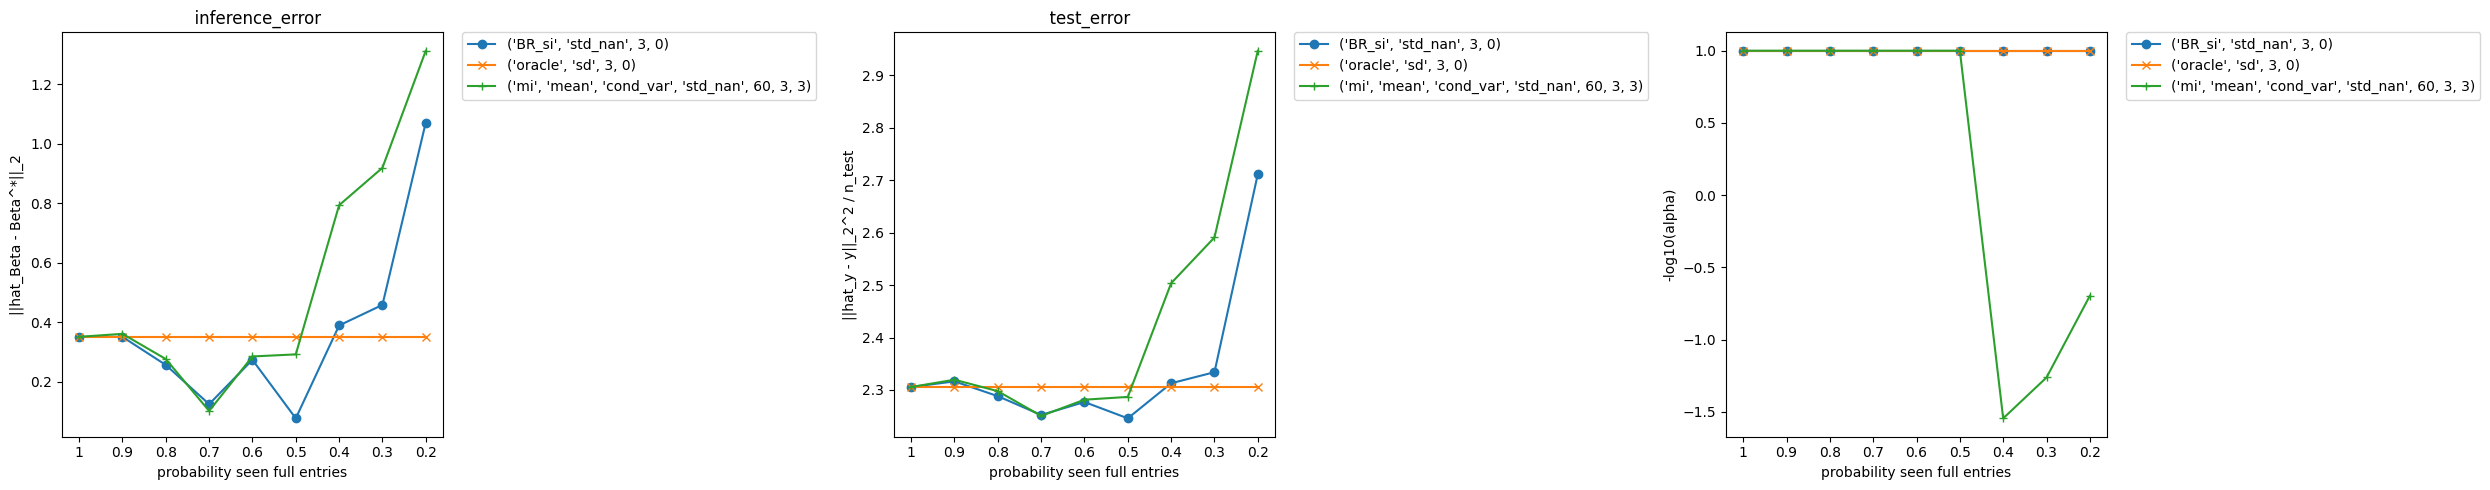

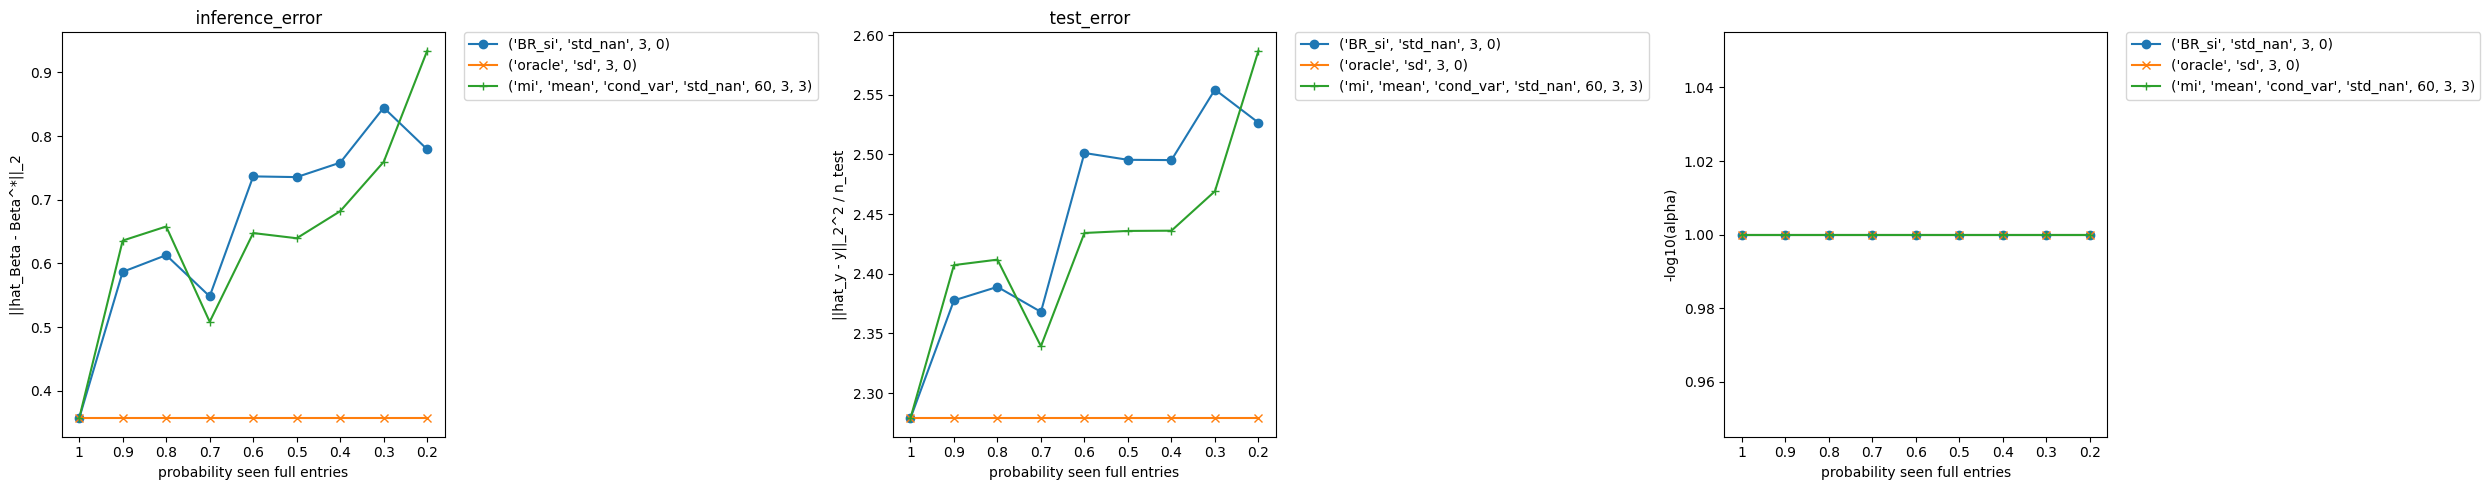

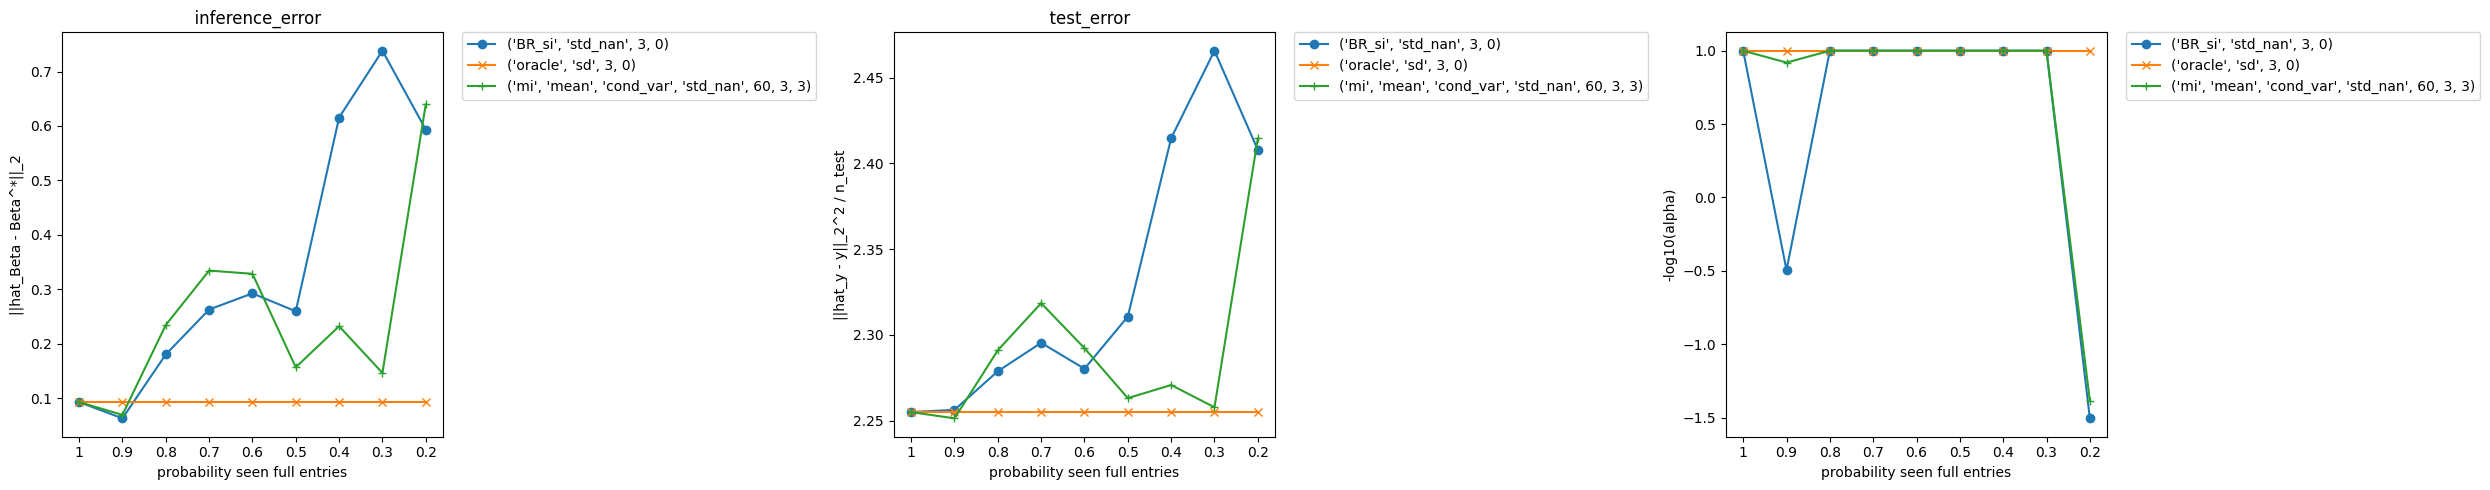

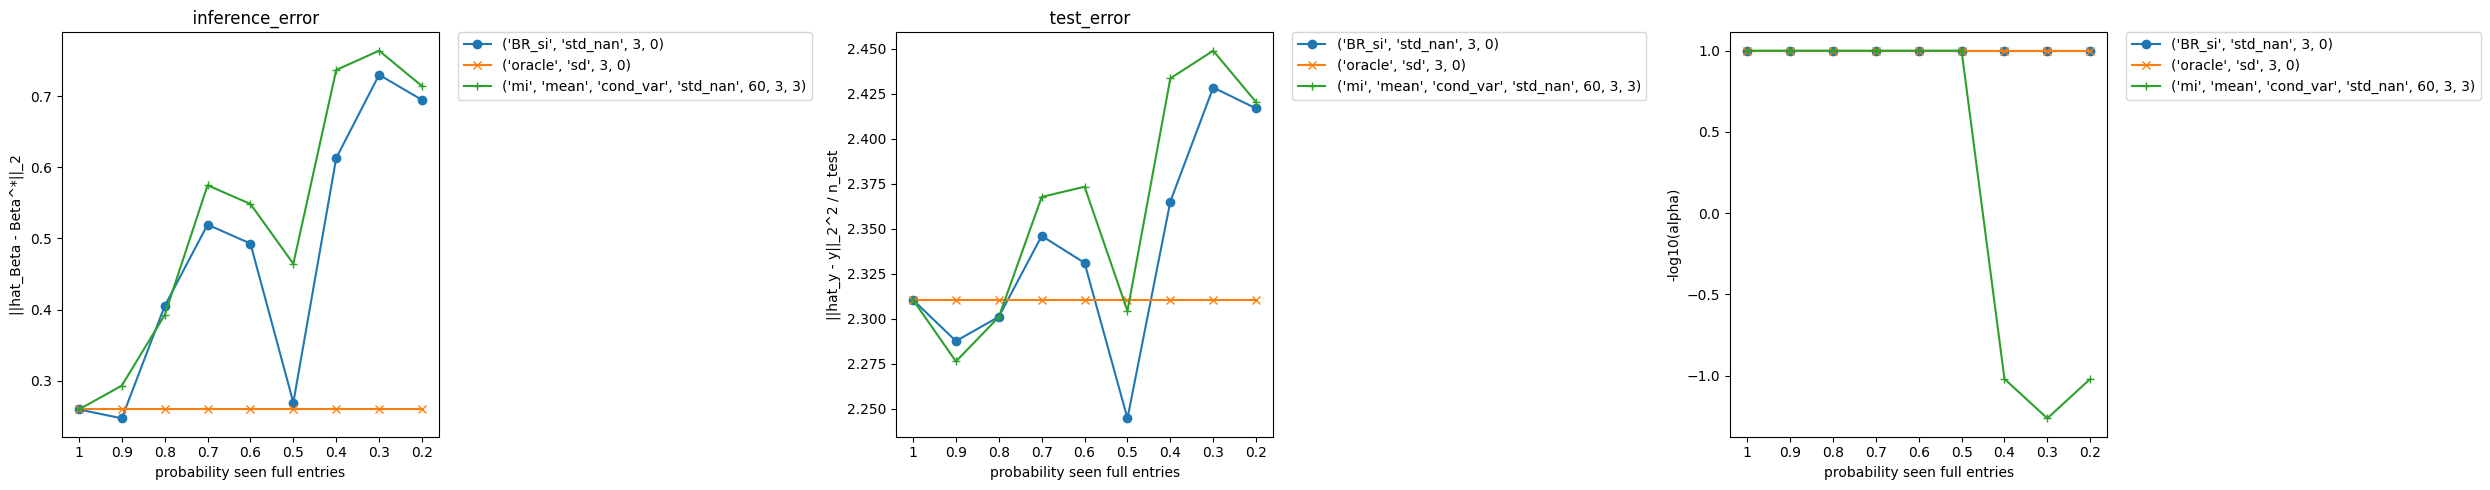

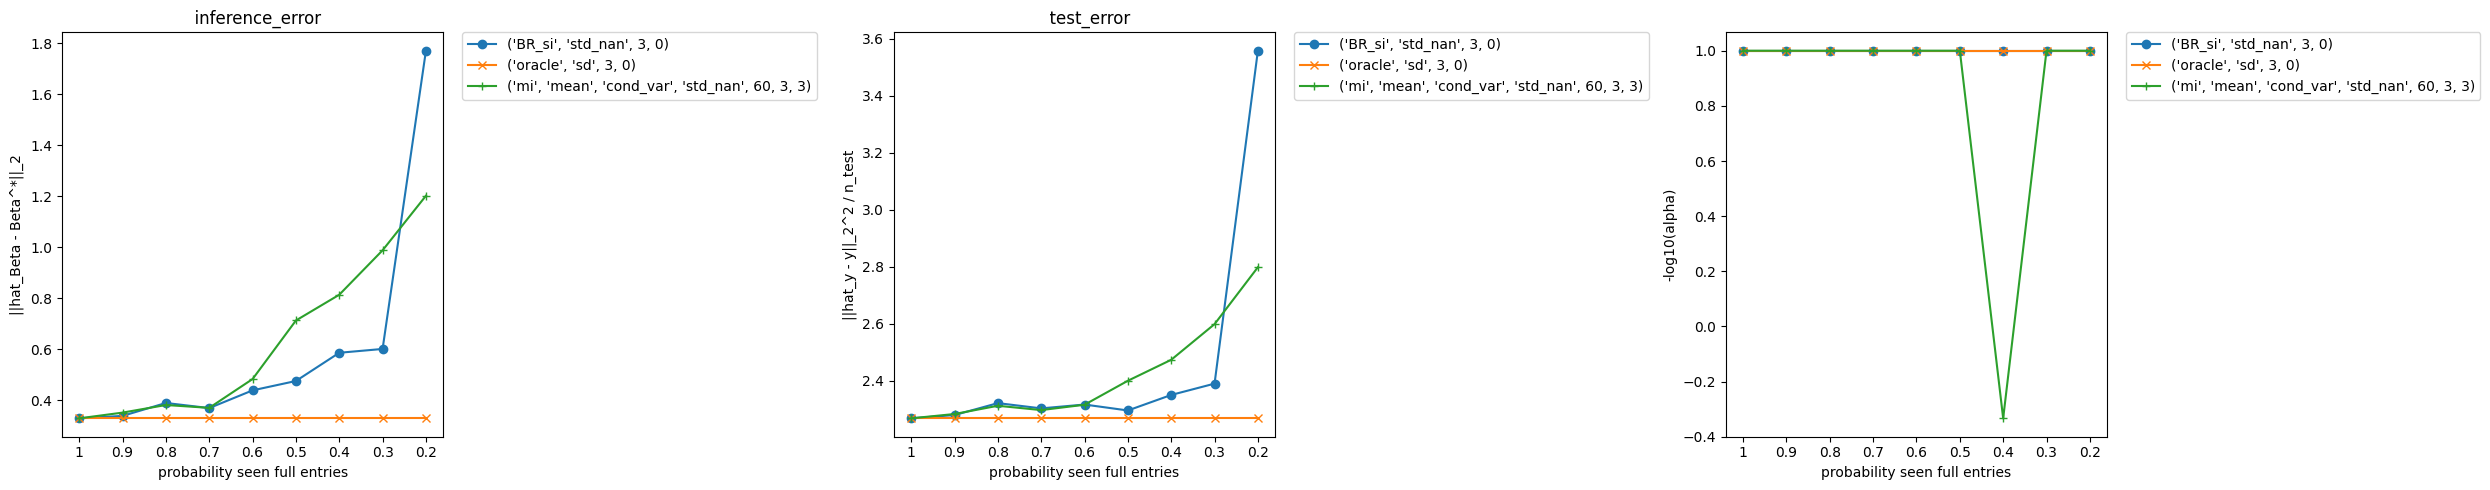

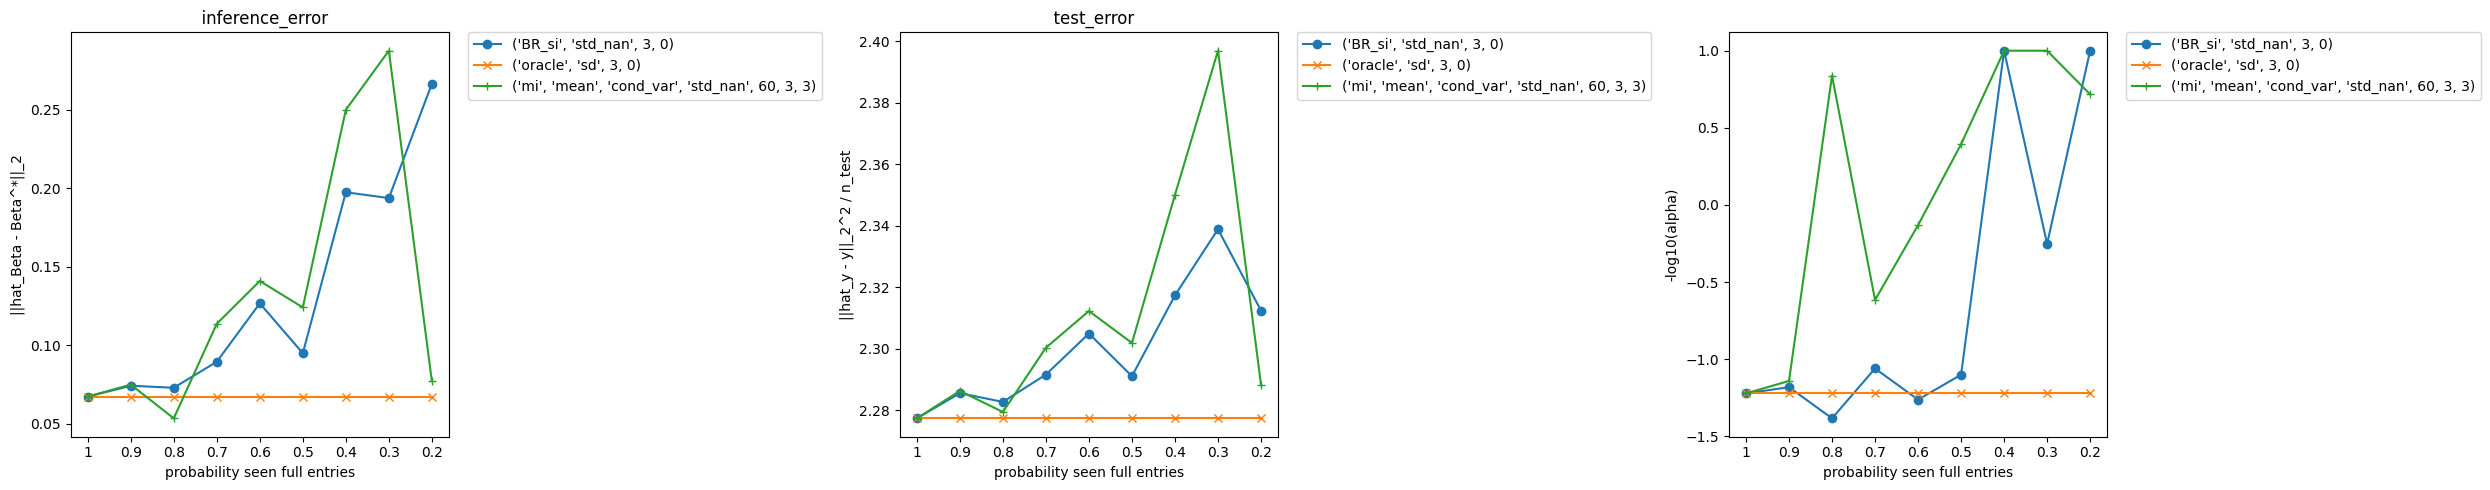

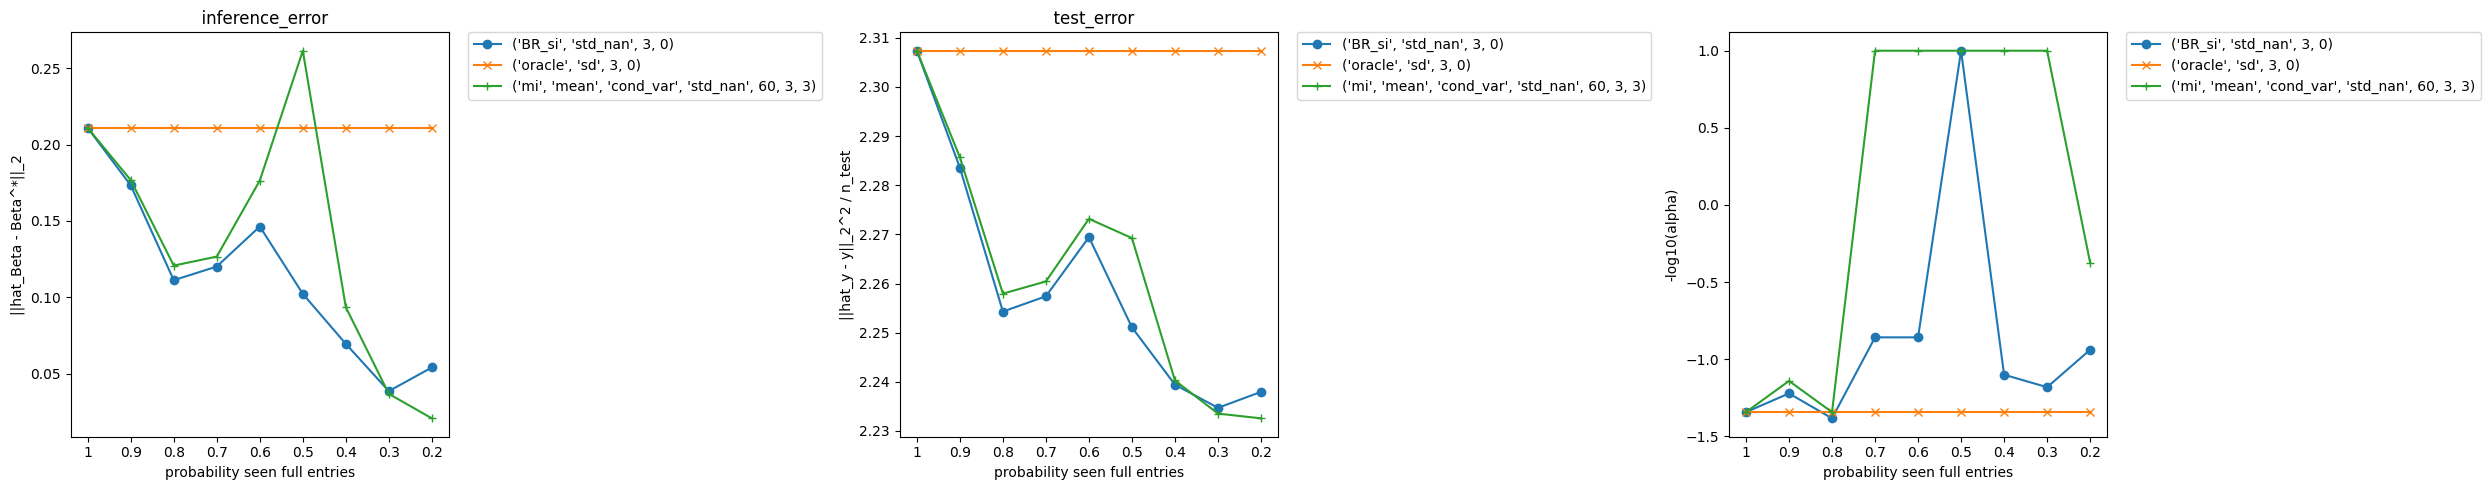

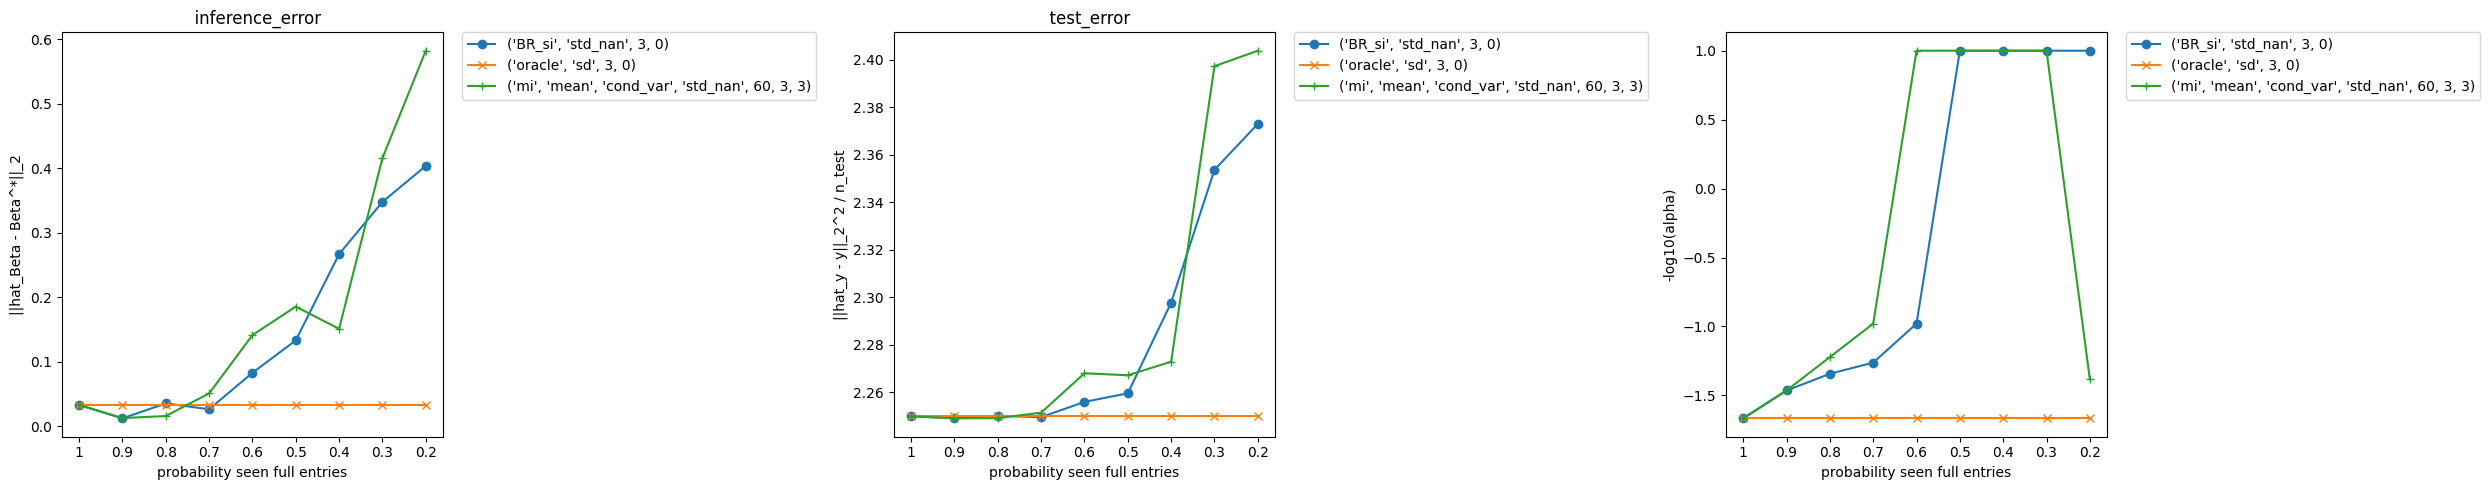

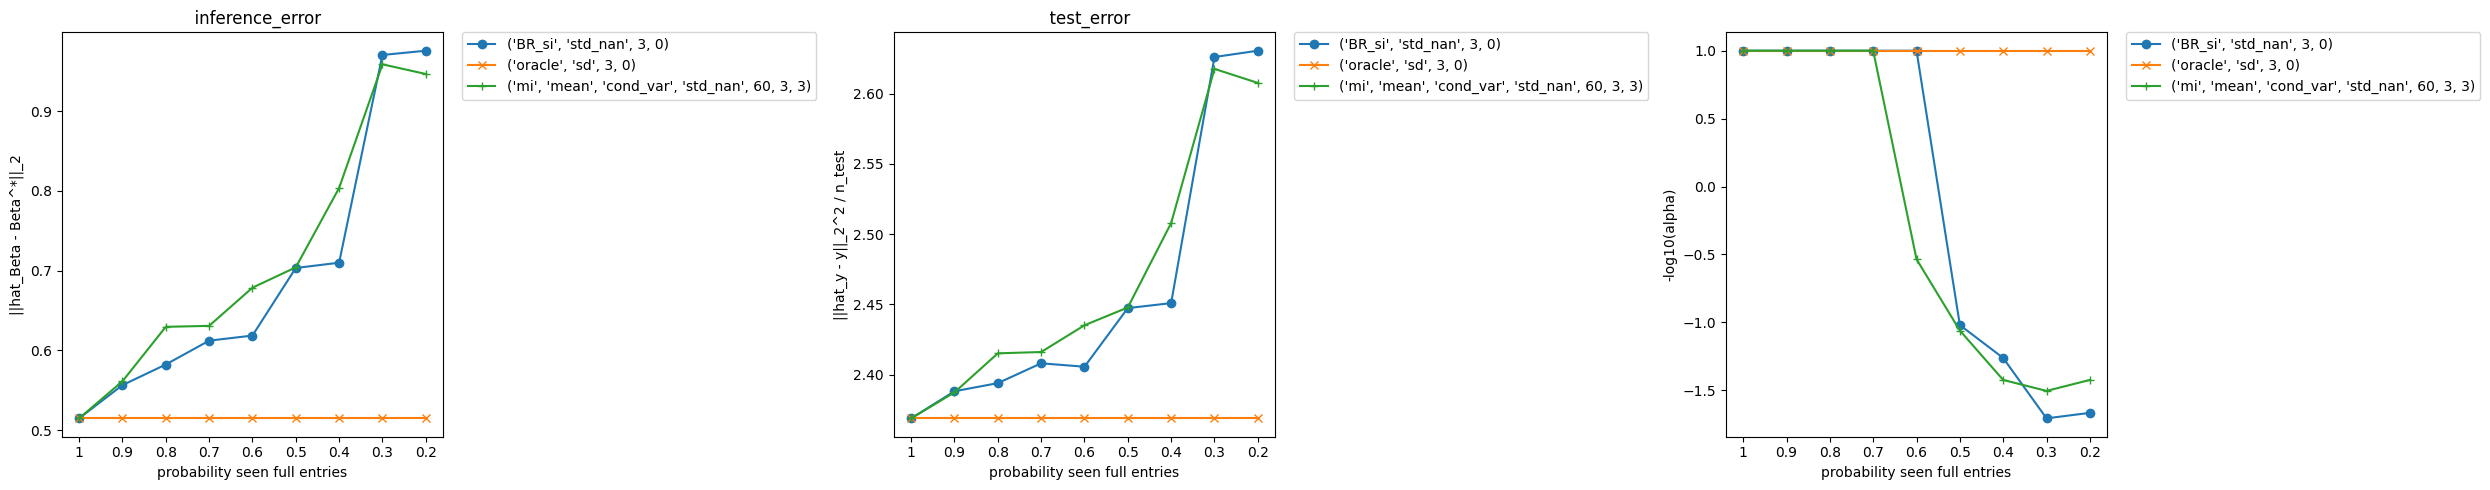

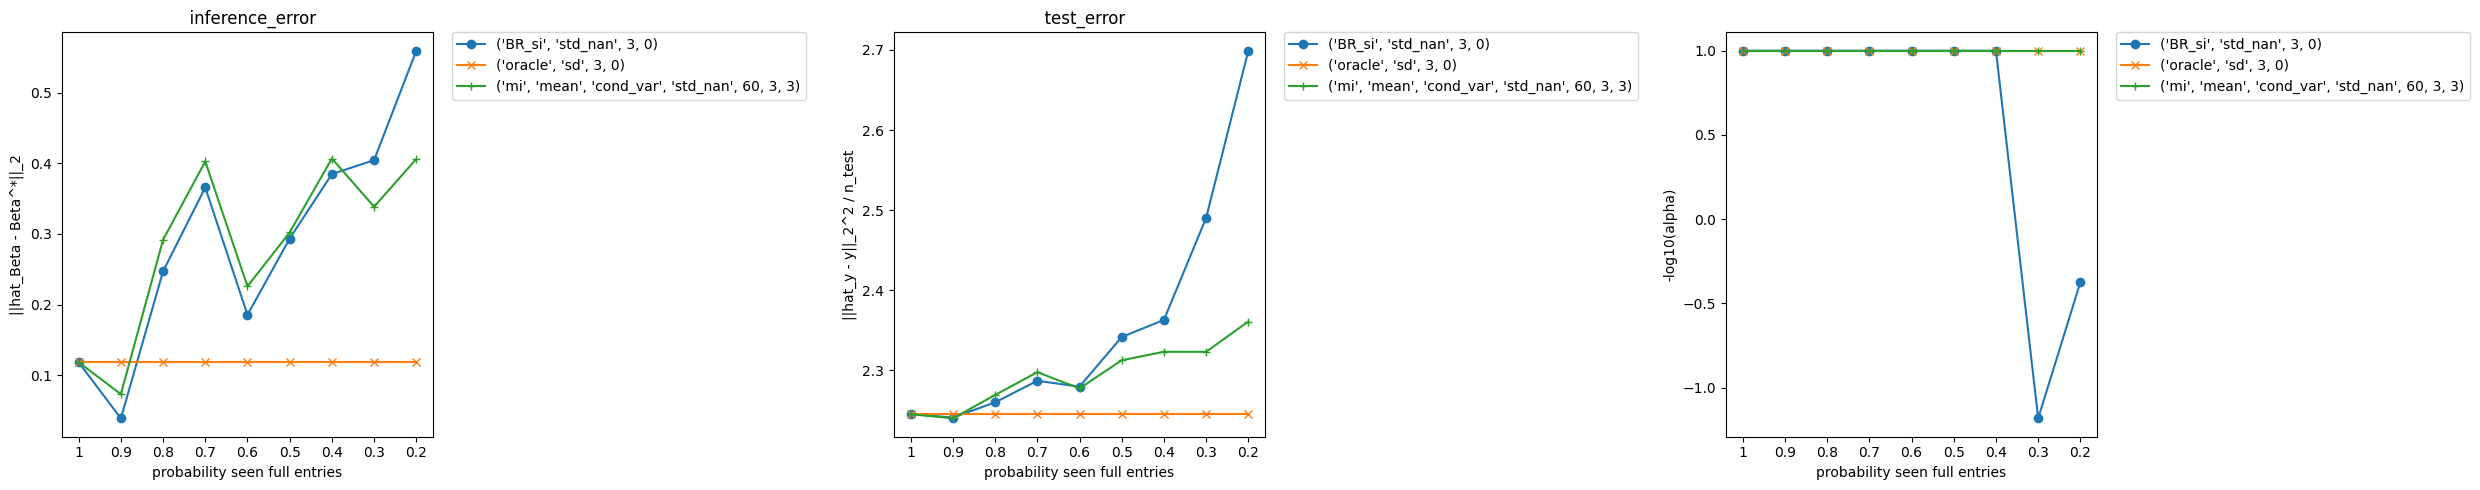

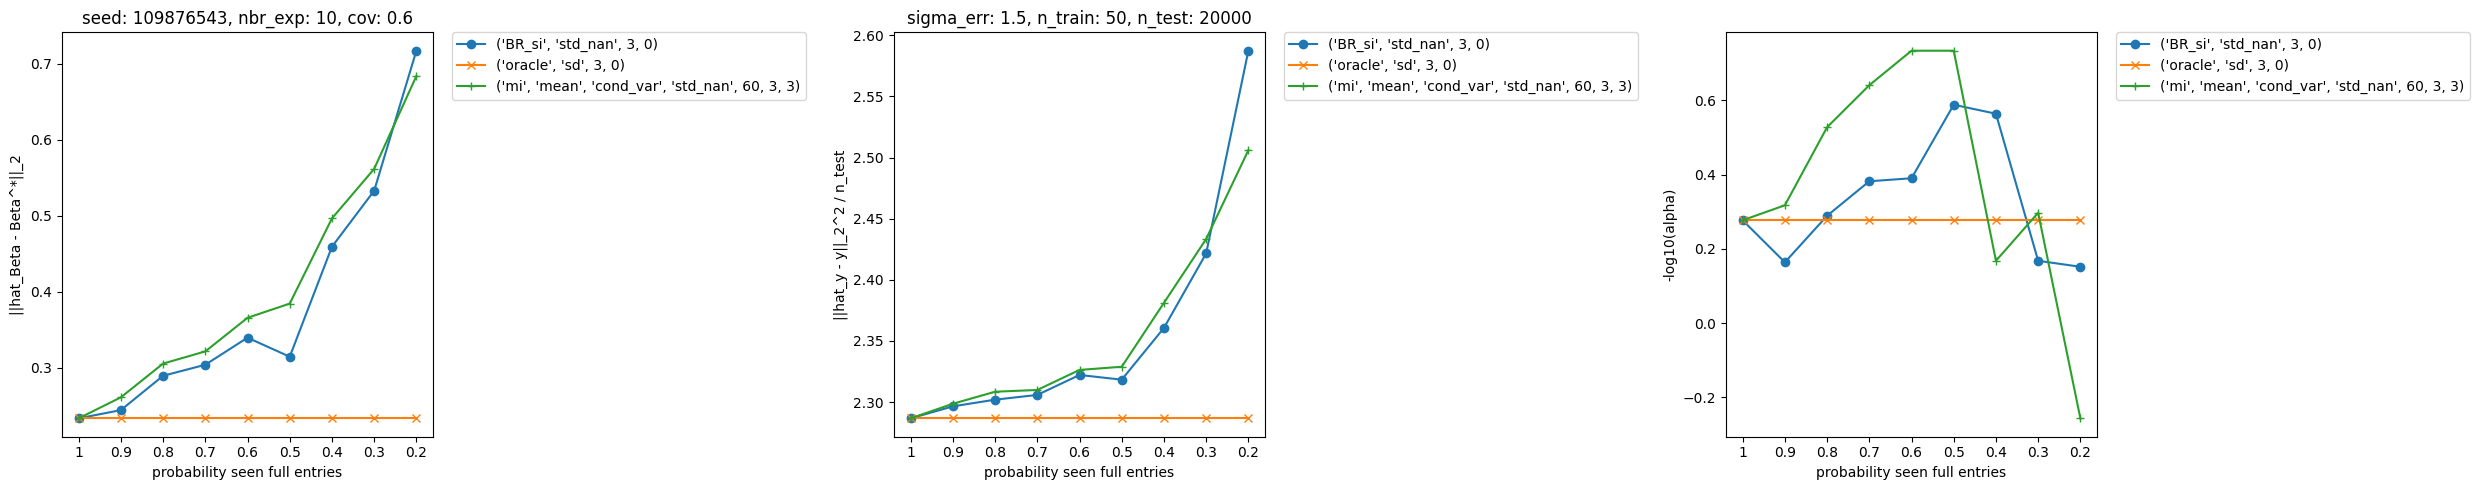

In [21]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1.5] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, cov_var], [cov_var, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 60
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 109876543
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [8]:
'''
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha
'''


'\nnp.random.seed(456789)\n\n#info_axis = \'train\'\n#n_train = [400, 800, 1200, 1600, 2000]\n#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])\n#main_vec = n_train if info_axis == \'train\' else p_seen\n#info_x_axis = make_info_axis(main_vec, info_axis)\n\ngen = \'fixed\'\ninfo_axis = \'p_seen\'  # train or p_seen\n#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]\n#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]\np_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]\n#p_seen_both = [1, 0.9, 0.8]\nlength_vec = len(p_seen_both)\n#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]\nn_train = [50] * length_vec\nerror_vec =  [1] * length_vec\np_seen = make_probabilities(p_seen_both)\nif info_axis == \'train\':\n  main_vec = n_train\nelif info_axis == \'p_seen\':\n  main_vec = p_seen_both\nelif info_axis == \'error\':\n  main_vec = erro

In [9]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[3 2]
  [3 4]]

 [[2 4]
  [2 2]]]
[[3 2]
 [3 4]
 [2 4]
 [2 2]]
[[[2 3]
  [4 4]
  [2 3]]]
[[2 3]
 [4 4]
 [2 3]]
[[3 3]
 [2 3]
 [2 4]
 [3 2]
 [3 4]]
[3 3 2 3 2 4 3 2 3 4]
other
[2 3 2 3 2]
[2 3 2 3 2 2 3 2 3 2 2 3 2 3 2]
other mult
[[3 4]
 [5 7]
 [6 3]]
[[3 4]
 [5 7]
 [6 3]
 [3 4]
 [5 7]
 [6 3]
 [3 4]
 [5 7]
 [6 3]]


In [10]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [11]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [12]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [13]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

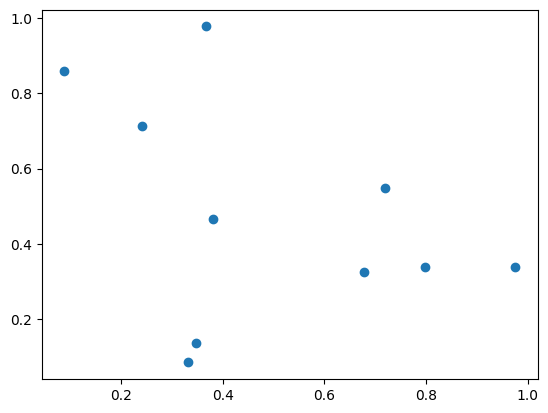

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]

